# Predicción de Quality Leads (QL)
## Problema
Cuando una persona registra su tienda en la plataforma tiene un periodo de prueba de 30 días en los cuales puede decidir si continuar o no utilizando el servicio. Durante el período de prueba la tienda es un trial. Una vez transcurridos los 30 días la tienda puede decidir continuar utilizando el servicio pero de forma paga, en ese caso se convierte en un payment.
En Tienda nuestro objetivo es brindarle a nuestros clientes la mejor calidad de atención. Pero dado el volumen de suscriptores diarios que viene registrando la plataforma de un tiempo a esta parte es muy dificultoso atenderlos a todos a la vez.
Para dar respuesta a este problema es necesario encontrar una forma de priorizar a nuestros clientes. Como Tienda no solo provee un servicio sino que también necesita ganar dinero para poder continuar operando, es necesario dar prioridad a aquellos potenciales clientes (trials) que van a continuar utilizando el servicio y pagando por el mismo (payment).
## Tareas a Desarrollar:
1. Desarrollar uno o varios modelos que permitan predecir con mayor exactitud los trials que se van a convertir en payments
   * Explicar brevemente cual fue el criterio por el cual se eligió el modelo y porqué se seleccionó dicha métrica
2. Obtener al menos 3 (insights) de lo obtenido por el modelo que puedan ser de utilidad para el negocio.


## Diccionario Dataset
* Id: Identificador númerico de los trials
* Country: país de origen del trial
* Creation_platform: plataforma por la cual se creó la tienda
* Admin_visits: cantidad de visitas que registró el administrador
* Intercom_conversations: cantidad de conversaciones que registró la tienda
con el equipo de soporte
* Source_pulido: origen de la tienda por campaña de marketing
* Creation_weekday: día de la semana en que se creó la tienda
* Creation_hour: hora del día en la que se creó la tienda
* Products_with_description: cantidad de productos que poseen descripción
* total_products_with_images: cantidad de productos que poseen imagen
* total_product_categories: cantidad de categorías de productos creadas
* total_events_on_Android: registro de la cantidad de eventos que tuvo el trial
por un dispositivo con sistema operativo Android
* total_events_on_Web: registro de la cantidad de eventos que tuvo el trial por
una computadora
* total_events_on_iOS: registro de la cantidad de eventos que tuvo el trial por un
dispositivo con sistema operativo iOS
* Target:
   * El trial luego del periodo de prueba se convirtió en payment
   * 0: El trial no se convirtió a payment

___
## 0. Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.cloud import storage
import requests
import pymysql.cursors


pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
from utils import plot_utils, transform_data

transformer = transform_data.Transformer('nb')

___
## 1. Upload data and create database

In [4]:
project_id = 'luminous-slice-344613'

### 1.1 Create a bucket and upload a .csv file

In [5]:
# Instantiates a client
credential_path = '/Users/ext_asalassa/Downloads/luminous-slice-344613-c17c8f3d9423.json'
storage_client = storage.Client.from_service_account_json(credential_path)

# The name for the new bucket
bucket_name = "ml2_data"

# Creates the new bucket
bucket = storage_client.create_bucket(bucket_name)

print("Bucket {} created.".format(bucket.name))

Bucket ml2_data created.


In [7]:
destination_blob_name = 'data.csv'
source_file_name = './data.csv'

bucket = storage_client.bucket(bucket_name)
blob = bucket.blob(destination_blob_name)

blob.upload_from_filename(source_file_name)

print("File {} uploaded to {}.".format(source_file_name, destination_blob_name))

File ./data.csv uploaded to data.csv.


In [9]:
df_remote = pd.read_csv('https://storage.googleapis.com/ml2_data/data.csv',  sep=';')
df_remote.head()

,row,id,country,creation_platform,admin_visits,intercom_conversations,source_pulido,creation_weekday,creation_hour,products_with_description,total_products_with_images,total_product_categories,total_events_on_Android,total_events_on_Web,total_events_on_iOS,target
0,0,589015,BR,mobile_app,1.0,0.0,Other,6,3,2.0,1,0.0,215.0,6.0,0.0,0
1,1,589016,BR,mobile_web,2.0,0.0,Google CPC no Brand,6,3,1.0,1,0.0,0.0,44.0,0.0,0
2,2,589017,BR,mobile_web,1.0,0.0,Google CPC no Brand,6,3,0.0,0,0.0,0.0,16.0,0.0,0
3,3,589018,BR,mobile_web,1.0,0.0,Google CPC no Brand,6,3,0.0,0,0.0,0.0,15.0,0.0,0
4,4,589019,BR,mobile_web,1.0,0.0,Google CPC no Brand,6,3,0.0,0,0.0,0.0,24.0,0.0,0


In [26]:
len(df_remote.columns)

16

### 1.2 Create a db in a mysql instance

In [ ]:
database_name = "machine_learning_2"

# Connect to the mysql instance
connection = pymysql.connect(host='34.133.178.66',
                             user='root',
                             password='1234',
                             cursorclass=pymysql.cursors.DictCursor)
                             
with connection:
    with connection.cursor() as cursor:
        # Create new database
        sql = f"CREATE DATABASE {database_name};"
        cursor.execute(sql)
        
    connection.commit()

In [78]:
table_name = 'dataset'

# Connect to the mysql instance
connection = pymysql.connect(host='34.133.178.66',
                             user='root',
                             password='1234',
                             cursorclass=pymysql.cursors.DictCursor,
                             db=database_name)

with connection:
    with connection.cursor() as cursor:
        # Create a new table
        sql = f"""
        DROP TABLE IF EXISTS {table_name};
        """
        cursor.execute(sql)

    connection.commit()

    
    with connection.cursor() as cursor:
        # Create a new table
        sql = f"""
        CREATE TABLE {table_name} (
            row INT NOT NULL,
            admin_visits DECIMAL(10,2) NOT NULL,
            country VARCHAR(255) NOT NULL,
            creation_hour INT NOT NULL,
            creation_platform VARCHAR(255) NOT NULL,
            creation_weekday INT NOT NULL,
            id INT NOT NULL,
            intercom_conversations DECIMAL(10,2) NOT NULL,
            products_with_description DECIMAL(10,2) NOT NULL,
            source_pulido VARCHAR(255) NOT NULL,
            target INT NOT NULL,
            total_events_on_Android DECIMAL(10,2) NOT NULL,
            total_events_on_Web DECIMAL(10,2) NOT NULL,
            total_events_on_iOS DECIMAL(10,2) NOT NULL,
            total_product_categories DECIMAL(10,2) NOT NULL,
            total_products_with_images INT NOT NULL,
            PRIMARY KEY (id)
        );
        """
        cursor.execute(sql)

    connection.commit()


In [79]:
# Connect to the mysql instance
connection = pymysql.connect(host='34.133.178.66',
                             user='root',
                             password='1234',
                             cursorclass=pymysql.cursors.DictCursor,
                             db=database_name)
                             
with connection:
    columns_selected = f"({','.join(df_remote.columns.values)})"
    step = 10000

    for idx in range(0, len(df_remote.index), step):
        print("New iterations")
        print("-",idx)
        values_string = ""
        
        for i in df_remote.index[idx:idx+step]:
            #print(i)
            values_string += "("
            
            for column in df_remote.columns:
                values_string += f"""{df_remote.iloc[i][column] if type(df_remote.iloc[i][column]) is not str else '"' + df_remote.iloc[i][column] + '"'},"""
            
            values_string = values_string[:-1]
            values_string += "),"

        values_string = values_string[:-1]

        with connection.cursor() as cursor:
            #print(columns_selected)
            #print(values_string)

            # Instert registers
            sql = f"""
            INSERT INTO {table_name}{columns_selected} VALUES {values_string}
            ;
            """
            cursor.execute(sql)


    connection.commit()


New iterations
- 0
New iterations
- 10000
New iterations
- 20000
New iterations
- 30000
New iterations
- 40000
New iterations
- 50000
New iterations
- 60000
New iterations
- 70000
New iterations
- 80000
New iterations
- 90000
New iterations
- 100000
New iterations
- 110000
New iterations
- 120000
New iterations
- 130000
New iterations
- 140000
New iterations
- 150000
New iterations
- 160000
New iterations
- 170000
New iterations
- 180000
New iterations
- 190000
New iterations
- 200000
New iterations
- 210000
New iterations
- 220000
New iterations
- 230000
New iterations
- 240000
New iterations
- 250000
New iterations
- 260000
New iterations
- 270000
New iterations
- 280000
New iterations
- 290000
New iterations
- 300000
New iterations
- 310000
New iterations
- 320000
New iterations
- 330000
New iterations
- 340000
New iterations
- 350000
New iterations
- 360000
New iterations
- 370000
New iterations
- 380000
New iterations
- 390000
New iterations
- 400000
New iterations
- 410000
New it

In [80]:
# Connect to the mysql instance
connection = pymysql.connect(host='34.133.178.66',
                             user='root',
                             password='1234',
                             cursorclass=pymysql.cursors.DictCursor,
                             db=database_name)
                             
with connection:
    with connection.cursor() as cursor:
        # Check insert
        sql = f"""
        SELECT COUNT(1) from {table_name}
        ;
        """
        cursor.execute(sql)
        result = cursor.fetchone()
        print(result)
    

    with connection.cursor() as cursor:
        # Check insert
        sql = f"""
        SELECT * from {table_name} LIMIT 1;
        """
        cursor.execute(sql)
        result = cursor.fetchall()
        print(result)


    connection.commit()


{'COUNT(1)': 585340}
[{'row': 0, 'admin_visits': Decimal('1.00'), 'country': 'BR', 'creation_hour': 3, 'creation_platform': 'mobile_app', 'creation_weekday': 6, 'id': 589015, 'intercom_conversations': Decimal('0.00'), 'products_with_description': Decimal('2.00'), 'source_pulido': 'Other', 'target': 0, 'total_events_on_Android': Decimal('215.00'), 'total_events_on_Web': Decimal('6.00'), 'total_events_on_iOS': Decimal('0.00'), 'total_product_categories': Decimal('0.00'), 'total_products_with_images': 1}]


___
## 2. Initial exploratory analysis

In [81]:
# Read dataset
df = pd.read_csv('./data.csv', sep=';')

# It is also possible to read it from the remote bucket, or using pd.read_sql_query with sqlalchemy, or fetch al table
# rows and create a dataframe from the result structure.

In [82]:
# Reorder columns by name
df = df.reindex(sorted(df.columns), axis=1)

In [83]:
# Show dataset head
df.head()

,admin_visits,country,creation_hour,creation_platform,creation_weekday,id,intercom_conversations,products_with_description,row,source_pulido,target,total_events_on_Android,total_events_on_Web,total_events_on_iOS,total_product_categories,total_products_with_images
0,1.0,BR,3,mobile_app,6,589015,0.0,2.0,0,Other,0,215.0,6.0,0.0,0.0,1
1,2.0,BR,3,mobile_web,6,589016,0.0,1.0,1,Google CPC no Brand,0,0.0,44.0,0.0,0.0,1
2,1.0,BR,3,mobile_web,6,589017,0.0,0.0,2,Google CPC no Brand,0,0.0,16.0,0.0,0.0,0
3,1.0,BR,3,mobile_web,6,589018,0.0,0.0,3,Google CPC no Brand,0,0.0,15.0,0.0,0.0,0
4,1.0,BR,3,mobile_web,6,589019,0.0,0.0,4,Google CPC no Brand,0,0.0,24.0,0.0,0.0,0


In [84]:
df.columns

Index(['admin_visits', 'country', 'creation_hour', 'creation_platform',
       'creation_weekday', 'id', 'intercom_conversations',
       'products_with_description', 'row', 'source_pulido', 'target',
       'total_events_on_Android', 'total_events_on_Web', 'total_events_on_iOS',
       'total_product_categories', 'total_products_with_images'],
      dtype='object')

In [88]:
# Delete unnecessary column
df.drop(labels='row', axis=1, inplace=True)

In [89]:
# Check
df.columns

Index(['admin_visits', 'country', 'creation_hour', 'creation_platform',
       'creation_weekday', 'id', 'intercom_conversations',
       'products_with_description', 'source_pulido', 'target',
       'total_events_on_Android', 'total_events_on_Web', 'total_events_on_iOS',
       'total_product_categories', 'total_products_with_images'],
      dtype='object')

In [90]:
# Show main statistics
print("Original quantity of examples:", df.shape[0])
print("Original quantity of columns", df.shape[1])
print("Dataset main statistics:")
df.describe()

Original quantity of examples: 585340
Original quantity of columns 15
Dataset main statistics:


,admin_visits,creation_hour,creation_weekday,id,intercom_conversations,products_with_description,target,total_events_on_Android,total_events_on_Web,total_events_on_iOS,total_product_categories,total_products_with_images
count,585340.000000,585340.000000,585340.000000,5.853400e+05,585340.000000,585340.000000,585340.000000,585340.000000,585340.000000,585340.000000,585340.000000,585340.000000
mean,1.091154,13.565886,2.725496,8.849227e+05,0.005793,5.232655,0.080071,7.105310,68.441636,0.895406,1.289987,5.198054
std,0.543782,7.157861,1.937653,1.711352e+05,0.118485,104.301081,0.271404,36.444225,124.612021,12.274338,9.712947,97.490506
min,0.000000,0.000000,0.000000,5.890150e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,10.000000,1.000000,7.365218e+05,0.000000,0.000000,0.000000,0.000000,11.000000,0.000000,0.000000,0.000000
50%,1.000000,15.000000,3.000000,8.847855e+05,0.000000,0.000000,0.000000,0.000000,27.000000,0.000000,0.000000,0.000000
75%,1.000000,19.000000,4.000000,1.032991e+06,0.000000,1.000000,0.000000,0.000000,70.000000,0.000000,0.000000,1.000000
max,22.000000,23.000000,6.000000,1.181809e+06,27.000000,28530.000000,1.000000,1706.000000,14596.000000,2527.000000,3059.000000,28530.000000


In [91]:
# dataset bigpicture
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 585340 entries, 0 to 585339
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   admin_visits                585340 non-null  float64
 1   country                     585340 non-null  object 
 2   creation_hour               585340 non-null  int64  
 3   creation_platform           585340 non-null  object 
 4   creation_weekday            585340 non-null  int64  
 5   id                          585340 non-null  int64  
 6   intercom_conversations      585340 non-null  float64
 7   products_with_description   585340 non-null  float64
 8   source_pulido               585340 non-null  object 
 9   target                      585340 non-null  int64  
 10  total_events_on_Android     585340 non-null  float64
 11  total_events_on_Web         585340 non-null  float64
 12  total_events_on_iOS         585340 non-null  float64
 13  total_product_

### Separation of features and labels

In [92]:
# Distinguishing between features and labels
label = 'target'
Y = df[label].copy()
X = df.drop([label, label], axis=1)
print("df shape:", df.shape)
print("X shape:", X.shape)
print("Y shape:", Y.shape)

df shape: (585340, 15)
X shape: (585340, 14)
Y shape: (585340,)


### Triming dataset based on column datatype

In [93]:
X_float = X.select_dtypes(include='float64')
X_float.shape

(585340, 7)

In [94]:
X_categorical = X.select_dtypes(include='object')
X_categorical.shape

(585340, 3)

In [95]:
X_int = X.select_dtypes(include='int64')
X_int.shape

(585340, 4)

### Analysis of variables 

#### Float variables

In [96]:
pd.concat([X_float.nunique(), X_float.nunique(dropna=False)], axis=1).T

,admin_visits,intercom_conversations,products_with_description,total_events_on_Android,total_events_on_Web,total_events_on_iOS,total_product_categories
0,9,17,1196,776,1479,425,291
1,9,17,1196,776,1479,425,291


No float column has missing values

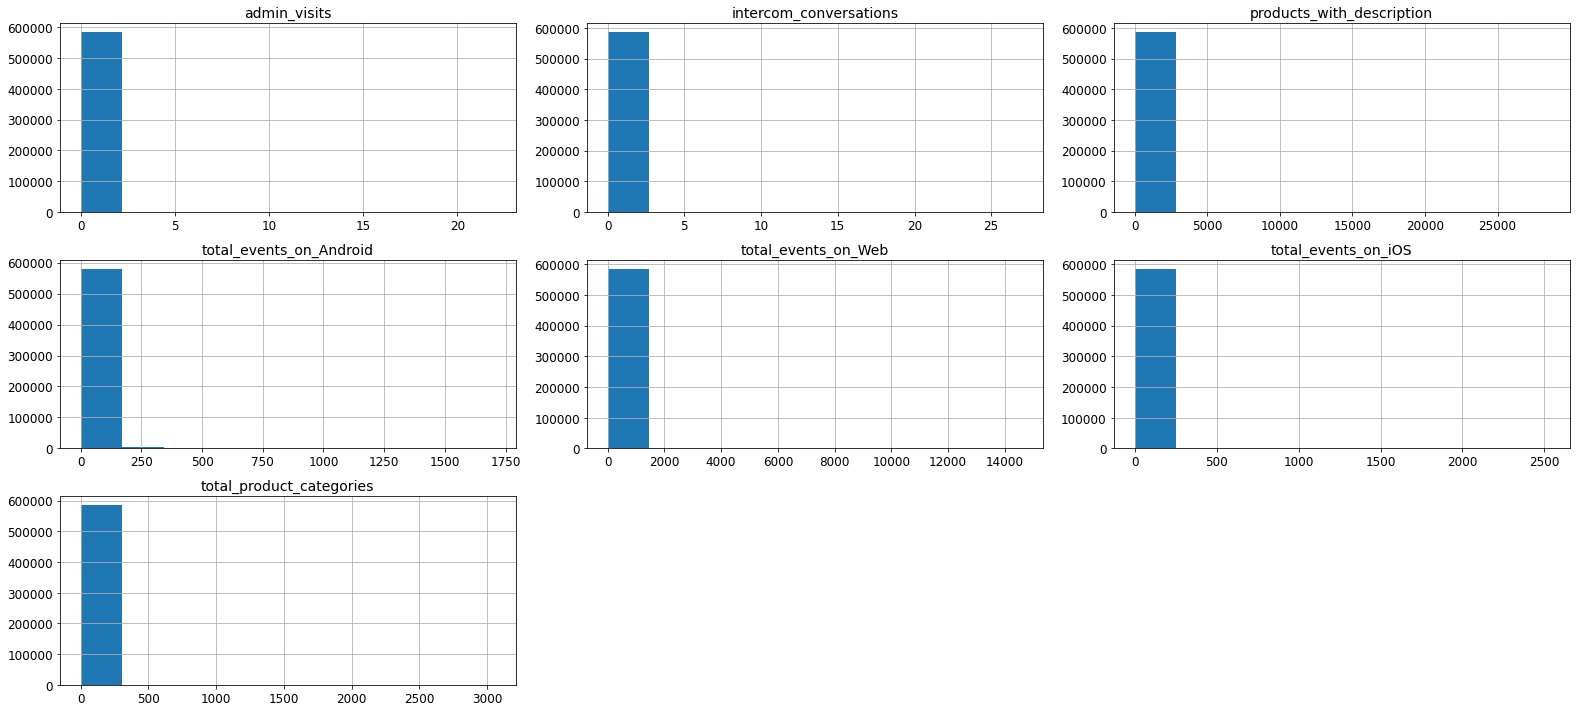

In [97]:
plot_utils.display_dataset_distributions(X_float)

<AxesSubplot:>

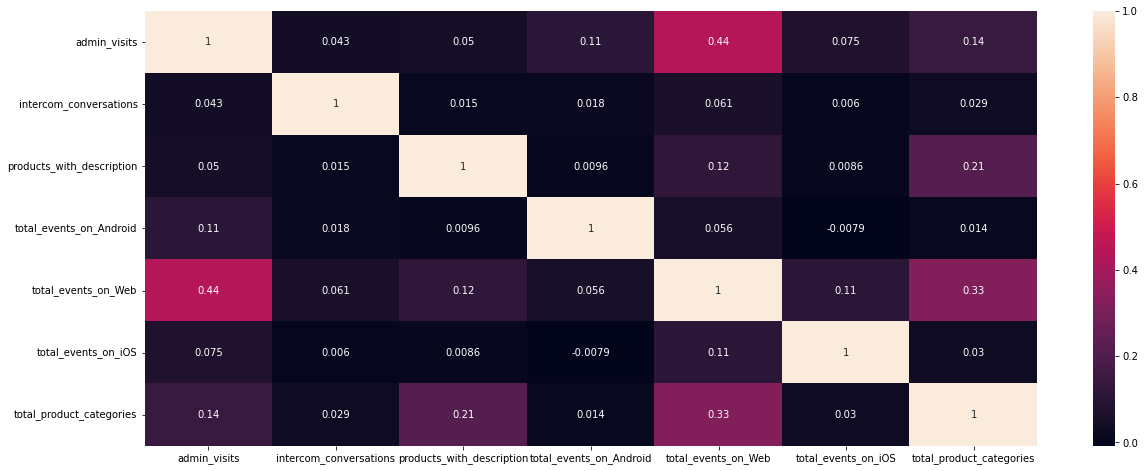

In [98]:
corrmat = X_float.corr()
plt.subplots(figsize=(20,8))
sns.heatmap(corrmat, annot=True, square=False)

From the correlation matrix above it can be seen that there are no strongly correlated variables.

#### Integer variables

In [99]:
pd.concat([X_int.nunique(), X_int.nunique(dropna=False)], axis=1).T

,creation_hour,creation_weekday,id,total_products_with_images
0,24,7,585340,1102
1,24,7,585340,1102


No int column has missing values. The *id* column will no be considered fot the next analysis

In [100]:
X_int.drop(labels='id', axis=1, inplace=True)

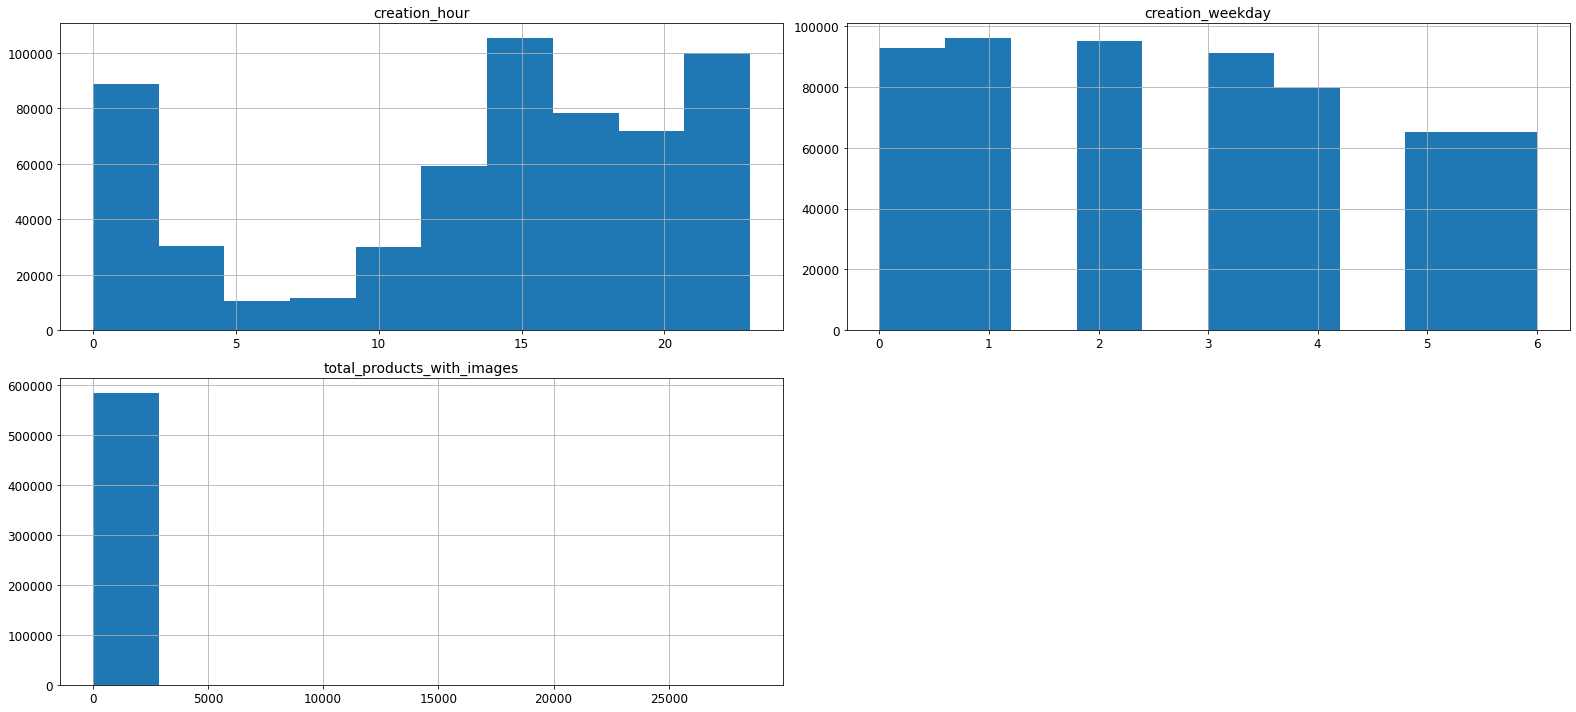

In [101]:
plot_utils.display_dataset_distributions(X_int)

*creation_weekday* and *creation_hour* should be considered as categorical variables

<AxesSubplot:>

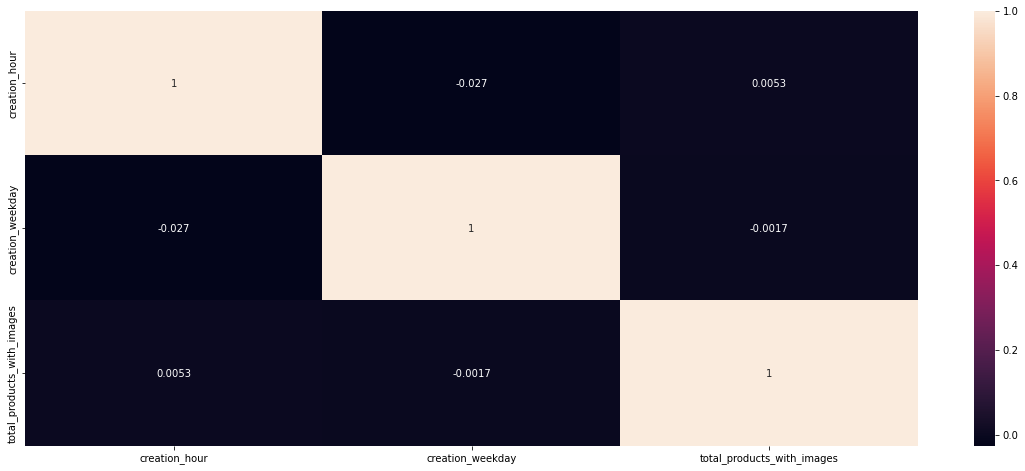

In [102]:
corrmat = X_int.corr()
plt.subplots(figsize=(20,8))
sns.heatmap(corrmat, annot=True, square=False)

From the correlation matrix above it can be seen that there are no strongly correlated variables.

<AxesSubplot:>

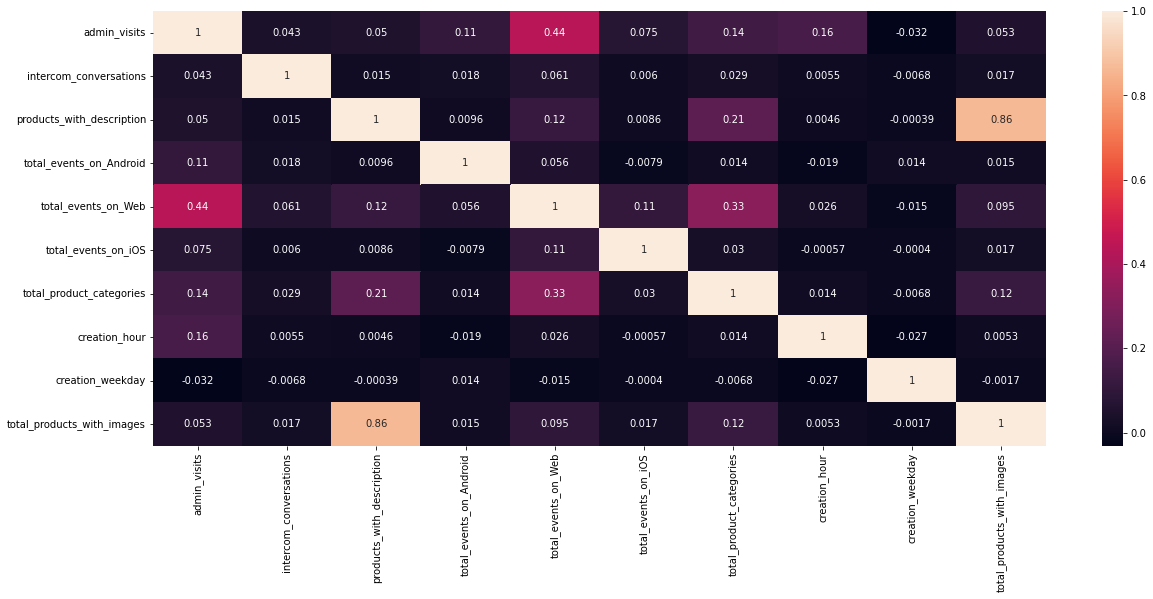

In [103]:
corrmat = pd.concat([X_float, X_int], axis=1).corr()
plt.subplots(figsize=(20,8))
sns.heatmap(corrmat, annot=True, square=False)

From the correlation matrix above it can be seen that there are no strongly correlated variables (more than 0.9). It can be inferred that sellers who have products with images also add description (in most cases).

#### Categorical variables

In [104]:
X_categorical = pd.concat([X_categorical, X_int[['creation_weekday', 'creation_hour']]], axis=1)

In [105]:
X_int.drop(labels=['creation_weekday', 'creation_hour'], axis=1, inplace=True)

In [106]:
pd.concat([X_categorical.nunique(), X_categorical.nunique(dropna=False)], axis=1).T

,country,creation_platform,source_pulido,creation_weekday,creation_hour
0,5,4,12,7,24
1,5,4,12,7,24


No categorical column has missing values

/Users/ext_asalassa/Documents/CEIA/4toBim/ml2/TP_FINAL/utils/plot_utils.py:36: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


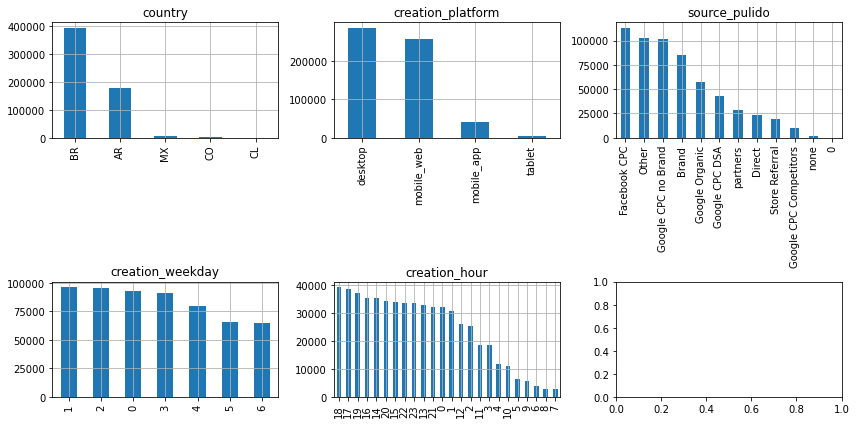

In [107]:
plot_utils.display_dataset_bar_value_count(X_categorical)

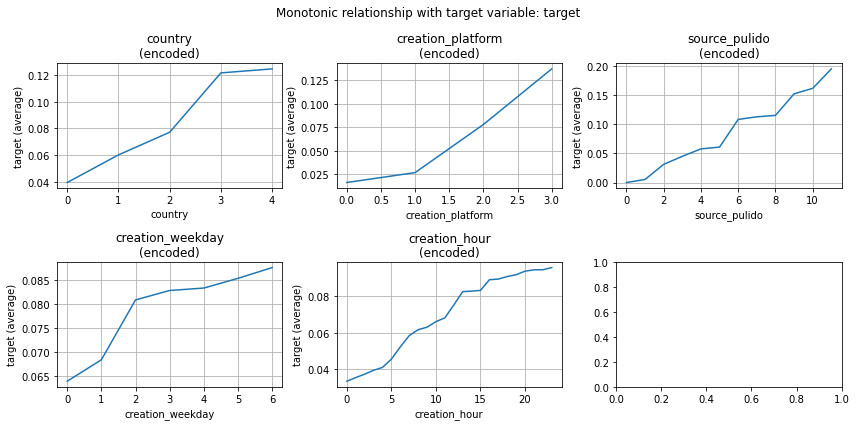

In [108]:
plot_utils.plot_cat_var_relations(X_categorical, Y, column_names=list(X_categorical.columns), label_name=label)

It is observed that all the categorical variables have a monotonic relationship with the target variable. So including them in the classification model would add value.

#### Label

In [109]:
print("Number of distinct values:", Y.nunique())
print("Number of distinct values including missing_values:", Y.nunique(dropna=False))
print("The possible values of Y are:", Y.unique())

Number of distinct values: 2
Number of distinct values including missing_values: 2
The possible values of Y are: [0 1]


There are no missing values in the target column

In [110]:
Y.value_counts()

0    538471
1     46869
Name: target, dtype: int64

In [111]:
y_aux = Y.value_counts()
print('percentage of trails that became payment:', 100*y_aux[1]/np.sum(y_aux))
print('percentage of trails that did not become payment:', 100*y_aux[0]/np.sum(y_aux))

percentage of trails that became payment: 8.00714114873407
percentage of trails that did not become payment: 91.99285885126594


The data is highly imabalanced. Class weights can be used for training

___
## 3. Train-test split

In [112]:
Y = df[label]
X = pd.concat([X_categorical, X_float, X_int], axis=1)
print(len(Y))
print(len(X))
print(X.columns)

585340
585340
Index(['country', 'creation_platform', 'source_pulido', 'creation_weekday',
       'creation_hour', 'admin_visits', 'intercom_conversations',
       'products_with_description', 'total_events_on_Android',
       'total_events_on_Web', 'total_events_on_iOS',
       'total_product_categories', 'total_products_with_images'],
      dtype='object')


In [113]:
train_proportion = 0.8
#val_proportion = 0.1
test_propportion = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=train_proportion, test_size=test_propportion, stratify=Y)
#X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=train_proportion, test_size=val_proportion+test_propportion)
#X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, train_size=val_proportion/(val_proportion+test_propportion), test_size=test_propportion/(val_proportion+test_propportion))

In [114]:
# Reset index is needed to perform transformations
X_train = X_train.reset_index()
#X_val = X_val.reset_index()
X_test = X_test .reset_index()

In [115]:
print("Dataset length:", len(X))
print("Training set length:", len(X_train))
#print("Validation set length:", len(X_val))
print("Test set length:", len(X_test))

Dataset length: 585340
Training set length: 468272
Test set length: 117068


___
## 4. Testing data preprocessing

### 4.1 Categorical variables

Mapping weekdays to avoid column name overlapping 

In [116]:
X_train['creation_weekday'] = X_train['creation_weekday'].map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})
X_train['creation_weekday']

0           Monday
1           Monday
2           Friday
3         Thursday
4           Monday
            ...   
468267    Saturday
468268     Tuesday
468269      Monday
468270     Tuesday
468271      Monday
Name: creation_weekday, Length: 468272, dtype: object

In [117]:
df_ohe = transformer.one_hot_encoding(X_train[list(X_categorical.columns)])
df_ohe.head()

,AR,BR,CL,CO,MX,desktop,mobile_app,mobile_web,tablet,0,...,14,15,16,17,18,19,20,21,22,23
0,0,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [118]:
# Check
pd.concat((X_train[['creation_weekday']], df_ohe[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]), axis=1)

,creation_weekday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,Monday,1,0,0,0,0,0,0
1,Monday,1,0,0,0,0,0,0
2,Friday,0,0,0,0,1,0,0
3,Thursday,0,0,0,1,0,0,0
4,Monday,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
468267,Saturday,0,0,0,0,0,1,0
468268,Tuesday,0,1,0,0,0,0,0
468269,Monday,1,0,0,0,0,0,0
468270,Tuesday,0,1,0,0,0,0,0


___
## 5. Feature seletion analysis

### 5.1 Numeric variables correlation

In [119]:
# Columnas inicialmente numéricas, previo a transformar.
columns_to_correlate = list(X_float.columns) + list(X_int.columns)
columns_to_correlate

['admin_visits',
 'intercom_conversations',
 'products_with_description',
 'total_events_on_Android',
 'total_events_on_Web',
 'total_events_on_iOS',
 'total_product_categories',
 'total_products_with_images']

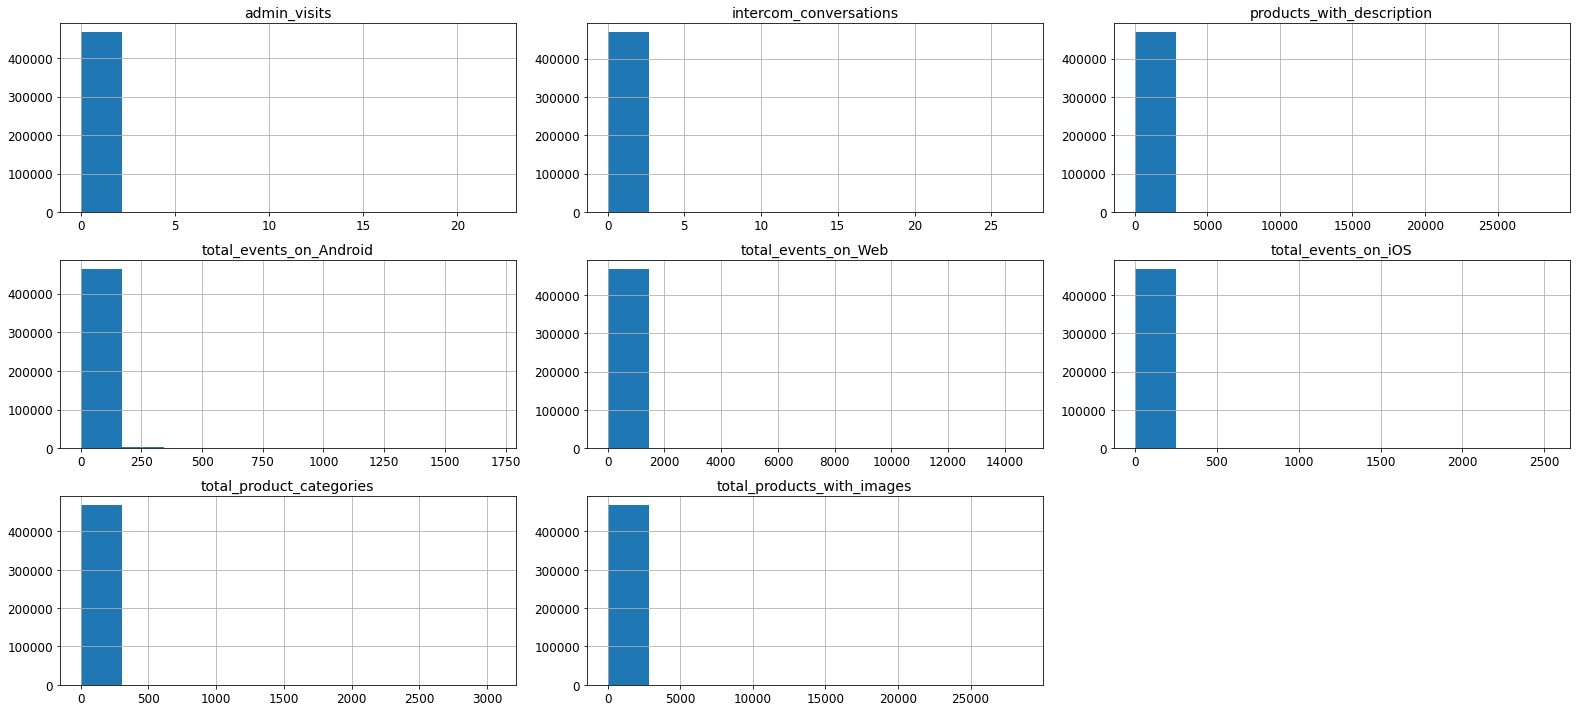

In [120]:
# Correlación sin normalizar
df_corr = X_train[columns_to_correlate].copy()
plot_utils.display_dataset_distributions(df_corr)

<AxesSubplot:>

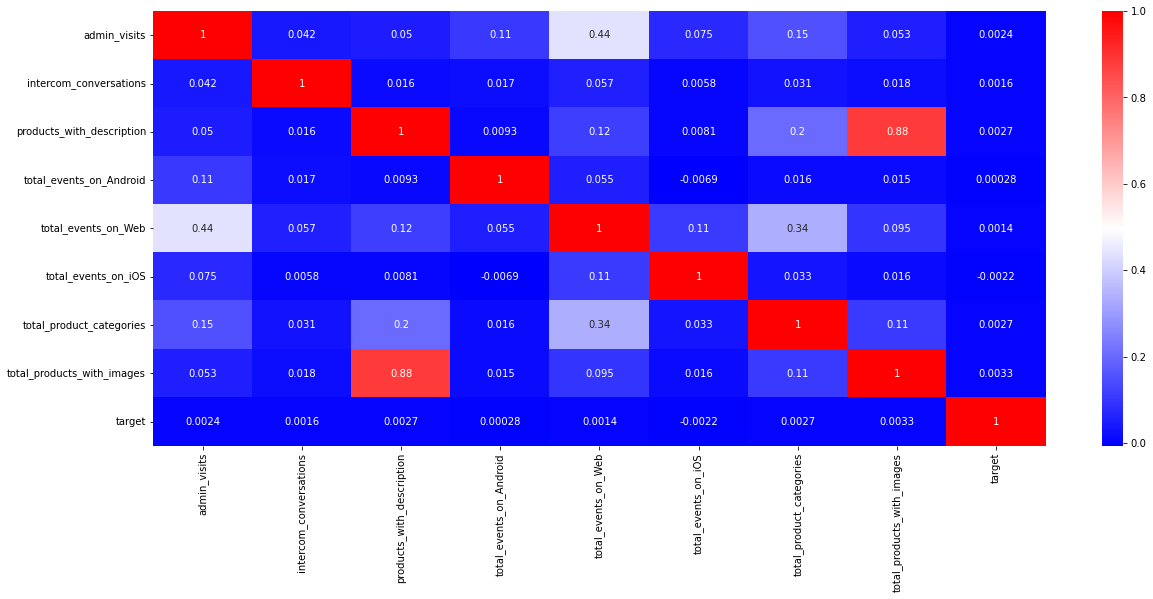

In [121]:
corr_mtx = pd.concat((df_corr, y_train), axis=1).corr()
plt.subplots(figsize=(20,8))
sns.heatmap(corr_mtx, annot=True, square=False, cmap='bwr')

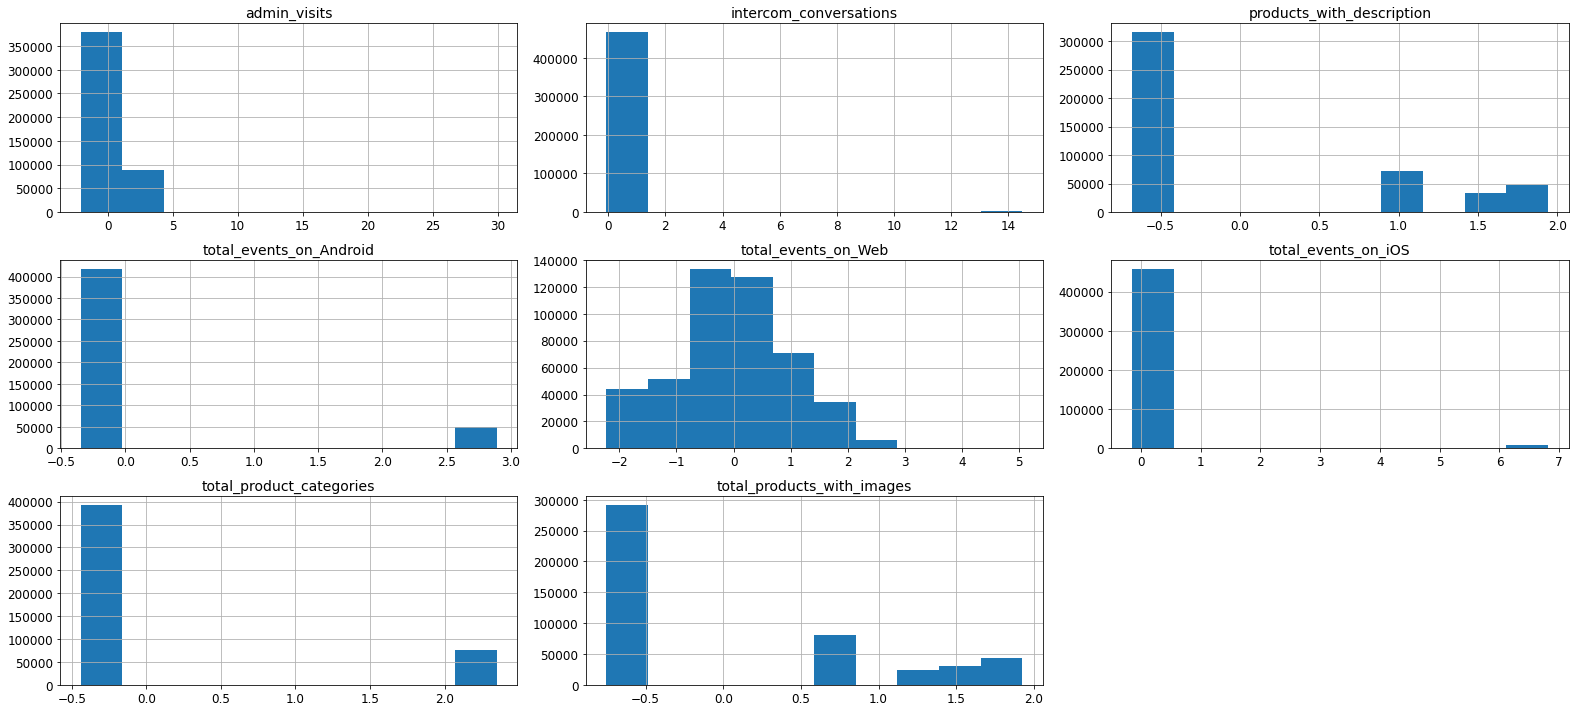

In [122]:
# Correlación normalizando normalizar
df_corr = transformer.power_transform(df_corr)
plot_utils.display_dataset_distributions(df_corr)

<AxesSubplot:>

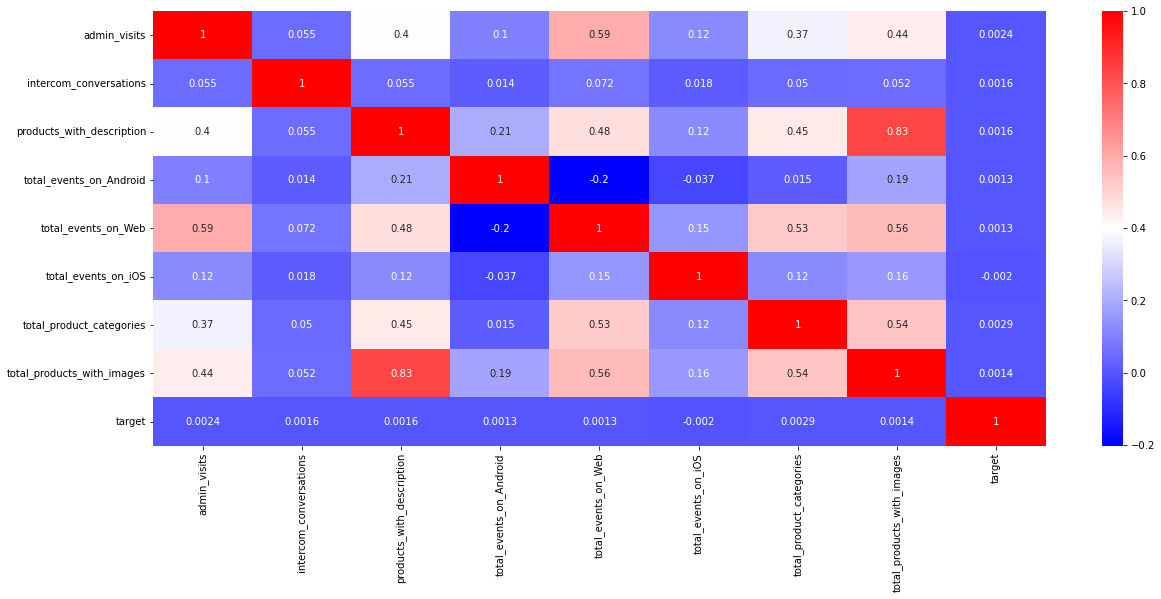

In [123]:
corr_mtx = pd.concat((df_corr, y_train), axis=1).corr()
plt.subplots(figsize=(20,8))
sns.heatmap(corr_mtx, annot=True, square=False, cmap='bwr')

### 5.2 Mutual information

In [124]:
from sklearn.feature_selection import mutual_info_regression

MI = mutual_info_regression(X_train[columns_to_correlate], y_train)

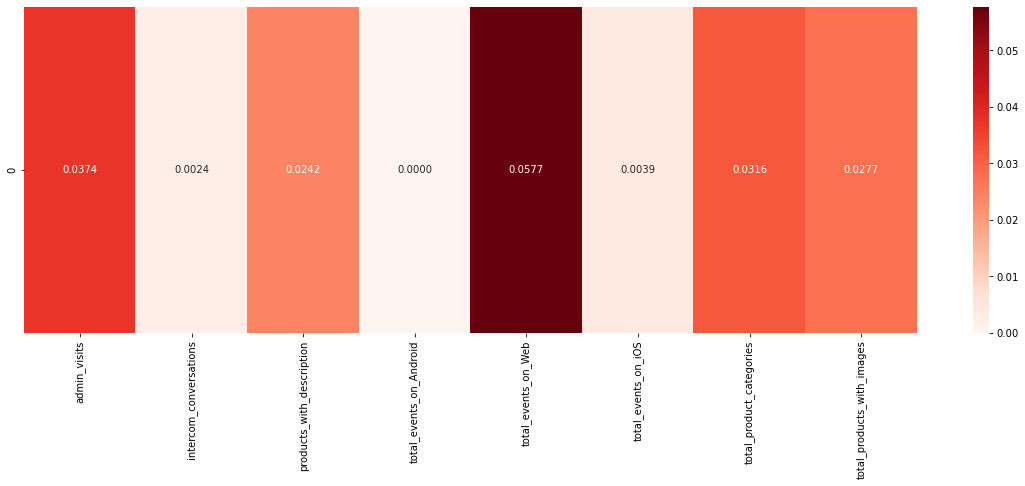

In [125]:
fig, ax = plt.subplots(1,1, figsize=(20,6))

sns.heatmap([MI], ax=ax, cmap='Reds', annot=True,fmt=".4f").set_xticklabels(columns_to_correlate)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

Surprisingly there is no mutual information between the Android mobile events and the target

In [126]:
columns_reduced = [
    'admin_visits',
    #'intercom_conversations',
    'products_with_description',
    #'total_events_on_Android',
    'total_events_on_Web',
    #'total_events_on_iOS',
    'total_product_categories',
    'total_products_with_images',
    #'total_mobile'
 ]

In [127]:
# Trying more variables
X_train['total_events'] = X_train[['total_events_on_Web', 'total_events_on_iOS', 'total_events_on_Android']].sum(axis=1)
X_train['total_mobile'] = X_train[['total_events_on_iOS', 'total_events_on_Android']].sum(axis=1)
ext_cols = ['total_events', 'total_mobile']

In [128]:
columns_0 = columns_to_correlate

In [129]:
columns_1 = [
    'admin_visits',
    'intercom_conversations',
    'products_with_description',
    #'total_events_on_Android',
    'total_events_on_Web',
    #'total_events_on_iOS',
    'total_product_categories',
    'total_products_with_images',
    'total_mobile'
 ]
MI_ext_1 = mutual_info_regression(X_train[columns_1], y_train)

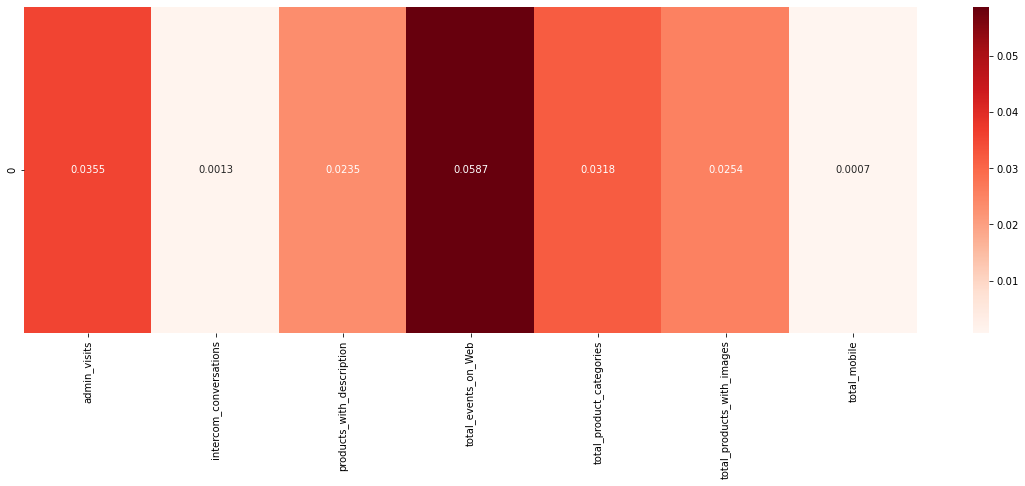

In [130]:
fig, ax = plt.subplots(1,1, figsize=(20,6))

sns.heatmap([MI_ext_1], ax=ax, cmap='Reds', annot=True,fmt=".4f").set_xticklabels(columns_1)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

In [131]:
columns_2 = [
    'admin_visits',
    'intercom_conversations',
    'products_with_description',
    #'total_events_on_Android',
    #'total_events_on_Web',
    #'total_events_on_iOS',
    'total_product_categories',
    'total_products_with_images',
    #'total_mobile',
    'total_events'
 ]
MI_ext_2 = mutual_info_regression(X_train[columns_2], y_train)

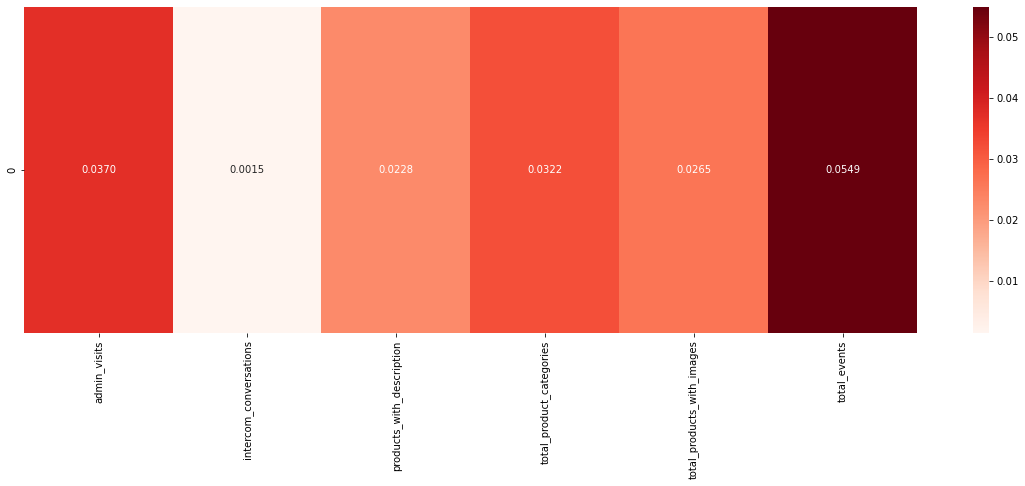

In [132]:
fig, ax = plt.subplots(1,1, figsize=(20,6))

sns.heatmap([MI_ext_2], ax=ax, cmap='Reds', annot=True,fmt=".4f").set_xticklabels(columns_2)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

#### Define different feature sets based on the previous graphics

In [133]:
fs_0 = list(set(columns_0).union(set(X_categorical.columns)))
fs_1 = list(set(columns_1).union(set(X_categorical.columns)))
fs_2 = list(set(columns_2).union(set(X_categorical.columns)))
fs_3 = list(set(columns_reduced).union(set(X_categorical.columns)))

print('fs_0 - Length:', len(fs_0), fs_0, '\n')
print('fs_1 - Length:', len(fs_1), fs_1, '\n')
print('fs_2 - Length:', len(fs_2), fs_2, '\n')
print('fs_3 - Length:', len(fs_3), fs_3, '\n')

fs_0 - Length: 13 ['total_events_on_Web', 'country', 'creation_hour', 'total_product_categories', 'intercom_conversations', 'creation_weekday', 'total_events_on_iOS', 'total_events_on_Android', 'products_with_description', 'total_products_with_images', 'creation_platform', 'source_pulido', 'admin_visits'] 

fs_1 - Length: 12 ['total_events_on_Web', 'total_mobile', 'country', 'creation_hour', 'total_product_categories', 'intercom_conversations', 'creation_weekday', 'products_with_description', 'total_products_with_images', 'creation_platform', 'source_pulido', 'admin_visits'] 

fs_2 - Length: 11 ['country', 'creation_hour', 'total_product_categories', 'intercom_conversations', 'creation_weekday', 'total_products_with_images', 'products_with_description', 'creation_platform', 'total_events', 'source_pulido', 'admin_visits'] 

fs_3 - Length: 10 ['total_events_on_Web', 'country', 'creation_hour', 'total_product_categories', 'creation_weekday', 'total_products_with_images', 'products_with_d

___
## 6. Training model and evaluation

### 6.0 Complete and transform test set

In [134]:
X_test['total_events'] = X_test[['total_events_on_Web', 'total_events_on_iOS', 'total_events_on_Android']].sum(axis=1)
X_test['total_mobile'] = X_test[['total_events_on_iOS', 'total_events_on_Android']].sum(axis=1)

In [135]:
X_test['creation_weekday'] = X_test['creation_weekday'].map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})

### 6.1 Input data preprocesor pipelines

In [138]:
from sklearn.preprocessing import RobustScaler, StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(categories="auto", drop=None, sparse=False, handle_unknown="ignore")
)])

categorical_transformer = OneHotEncoder(categories="auto", drop=None, sparse=False, handle_unknown="ignore")

preprocessor_0 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, columns_0),
        ('cat', categorical_transformer, list(X_categorical.columns)),
    ]
)

preprocessor_1 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, columns_1),
        ('cat', categorical_transformer, list(X_categorical.columns)),
    ]
)

preprocessor_2 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, columns_2),
        ('cat', categorical_transformer, list(X_categorical.columns)),
    ]
)

preprocessor_3 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, columns_reduced),
        ('cat', categorical_transformer, list(X_categorical.columns)),
    ]
)

### 6.2 Model trainings

In [222]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, accuracy_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import xgboost as xgb
import mlflow

In [162]:
results = {}

In [223]:
mlflow.sklearn.autolog()
mlflow.set_experiment('ml2')

<Experiment: artifact_location='file:///Users/ext_asalassa/Documents/CEIA/4toBim/ml2/TP_FINAL/mlruns/1', experiment_id='1', lifecycle_stage='active', name='ml2', tags={}>

#### 6.2.1 Logistic Regression

In [225]:
param_grid_LR = {
    'classifier__penalty': ['l1', 'l2', 'elasticnet'], 
    'classifier__C': [0.5, 1.0, 1.5]
}

___

In [181]:
modelLR_0 = Pipeline(steps=[
                            ('preprocessor', preprocessor_0),
                            ('classifier', LogisticRegression(verbose=False, max_iter=50, tol = 0.00001))
                            ],
                    verbose=False)

In [184]:
search_modelLR_0 = GridSearchCV(modelLR_0, param_grid_LR)

with mlflow.start_run(run_name="modelLR_0") as run_modelLR_0:
    search_modelLR_0.fit(X_train[fs_0], y_train)

2022/04/17 17:02:46 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler(...`
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/mlflow/utils/autologging_utils/safety.py", line 548, in safe_patch_function
    patch_function(call_original, *arg

Accuracy: 91.97%


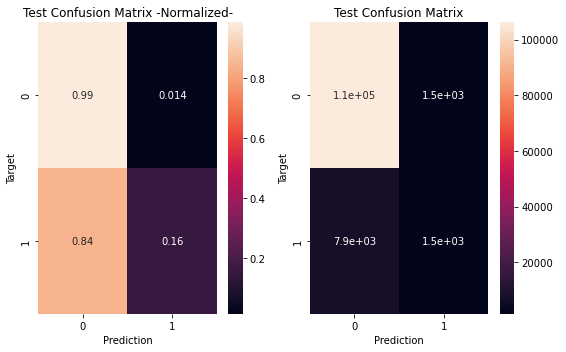

In [186]:
test_preds_LR_0 = search_modelLR_0.predict(X_test[fs_0])
plot_utils.predict_and_plot(test_preds_LR_0, y_test, 'Test')
acc = search_modelLR_0.score(X_test[fs_0], y_test)
rec = recall_score(y_true=y_test, y_pred=test_preds_LR_0)
f1 = f1_score(y_true=y_test, y_pred=test_preds_LR_0)

<ipython-input-187-076b84a8878b>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


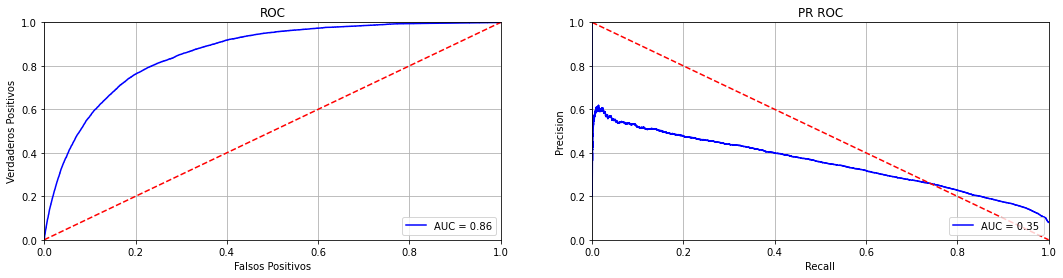

In [187]:
y_pred_LR_0 = search_modelLR_0.predict_proba(X_test[fs_0])

preds_LR_0 = y_pred_LR_0[:,1]

fpr, tpr, threshold = roc_curve(y_test, preds_LR_0)
roc_auc_LR_0 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_LR_0)
pr_roc_auc_LR_0 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_LR_0)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_LR_0)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [188]:
results['modelLR_0'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_LR_0, 'prc': pr_roc_auc_LR_0, 'params': search_modelLR_0.best_params_}
results['modelLR_0']

{'acc': 0.9196877028735436,
 'rec': 0.15767015148282484,
 'f1': 0.2391972811134488,
 'auc': 0.8597609093333529,
 'prc': 0.3538795739675172,
 'params': {'classifier__C': 1.0, 'classifier__penalty': 'l2'}}

___

In [189]:
modelLR_1 = Pipeline(steps = [
                            ('preprocessor', preprocessor_1),
                            ('classifier', LogisticRegression(verbose=False, max_iter=50, tol = 0.00001))
                            ],
                    verbose=False)

In [190]:
search_modelLR_1 = GridSearchCV(modelLR_1, param_grid_LR)

with mlflow.start_run(run_name='modelLR_1') as run_modelLR_1:
    search_modelLR_1.fit(X_train[fs_1], y_train)

2022/04/17 17:04:25 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler(...`
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/mlflow/utils/autologging_utils/safety.py", line 548, in safe_patch_function
    patch_function(call_original, *arg

Accuracy: 92.11%


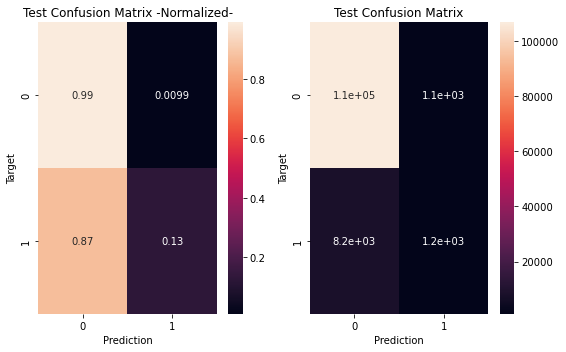

In [191]:
test_preds_LR_1 = search_modelLR_1.predict(X_test[fs_1])
plot_utils.predict_and_plot(test_preds_LR_1, y_test, 'Test')
acc = search_modelLR_1.score(X_test[fs_1], y_test)
rec = recall_score(y_true=y_test, y_pred=test_preds_LR_1)
f1 = f1_score(y_true=y_test, y_pred=test_preds_LR_1)

<ipython-input-192-a34d74e2170a>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


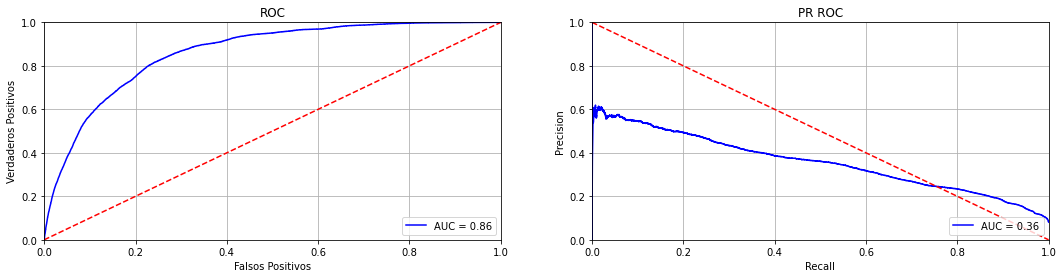

In [192]:
y_pred_LR_1 = search_modelLR_1.predict_proba(X_test[fs_1])

preds_LR_1 = y_pred_LR_1[:,1]

fpr, tpr, threshold = roc_curve(y_test, preds_LR_1)
roc_auc_LR_1 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_LR_1)
pr_roc_auc_LR_1 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_LR_1)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_LR_1)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [193]:
results['modelLR_1'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_LR_1, 'prc': pr_roc_auc_LR_1, 'params': search_modelLR_1.best_params_}
results['modelLR_1']

{'acc': 0.9211142242115693,
 'rec': 0.12822701088116065,
 'f1': 0.20654695420568778,
 'auc': 0.8613121648644324,
 'prc': 0.3562343166162722,
 'params': {'classifier__C': 0.5, 'classifier__penalty': 'l2'}}

___

In [194]:
modelLR_2 = Pipeline(steps=[('preprocessor', preprocessor_2),
                       ('classifier', LogisticRegression(verbose=True, max_iter=50, tol = 0.00001))])

In [195]:
search_modelLR_2 = GridSearchCV(modelLR_2, param_grid_LR)

with mlflow.start_run(run_name='modelLR_2') as run_modelLR_2:
    search_modelLR_2.fit(X_train[fs_2], y_train)

2022/04/17 17:11:28 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler(...`
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/mlflow/utils/autologging_utils/safety.py", line 548, in safe_patch_function
    patch_function(call_original, *arg

Accuracy: 92.09%


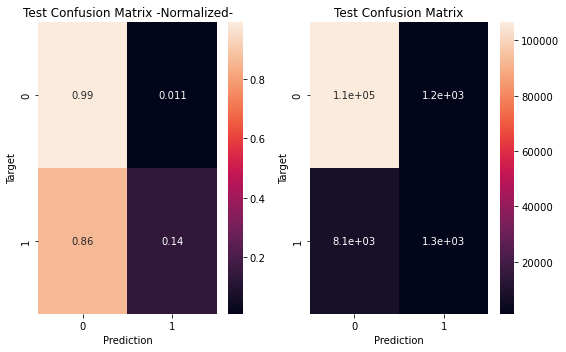

In [196]:
test_preds_LR_2 = search_modelLR_2.predict(X_test[fs_2])
plot_utils.predict_and_plot(test_preds_LR_2, y_test, 'Test')
acc = search_modelLR_2.score(X_test[fs_2], y_test)
rec = recall_score(y_true=y_test, y_pred=test_preds_LR_2)
f1 = f1_score(y_true=y_test, y_pred=test_preds_LR_2)

<ipython-input-197-5cf793ff9514>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


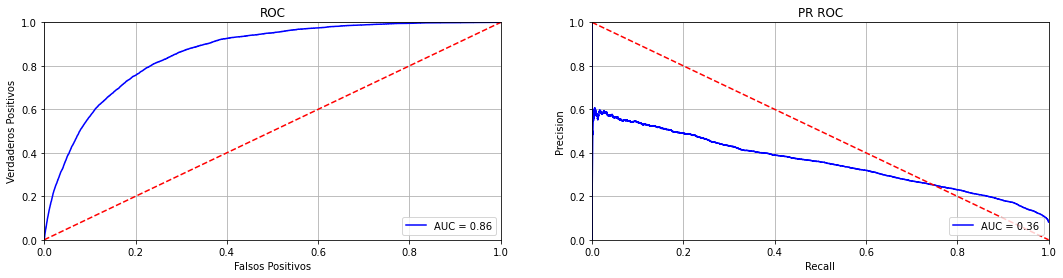

In [197]:
y_pred_LR_2 = search_modelLR_2.predict_proba(X_test[fs_2])

preds_LR_2 = y_pred_LR_2[:,1]

fpr, tpr, threshold = roc_curve(y_test, preds_LR_2)
roc_auc_LR_2 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_LR_2)
pr_roc_auc_LR_2 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_LR_2)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_LR_2)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [200]:
results['modelLR_2'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_LR_2, 'prc': pr_roc_auc_LR_2, 'params': search_modelLR_2.best_params_}
results['modelLR_2']

{'acc': 0.9208665049373014,
 'rec': 0.13782803499039897,
 'f1': 0.21809588116137743,
 'auc': 0.8619603929281666,
 'prc': 0.355233615830399,
 'params': {'classifier__C': 0.5, 'classifier__penalty': 'l2'}}

___

In [201]:
modelLR_3 = Pipeline(steps=[('preprocessor', preprocessor_3),
                       ('classifier', LogisticRegression(verbose=True, max_iter=50, tol = 0.00001))])

In [202]:
search_modelLR_3 = GridSearchCV(modelLR_3, param_grid_LR)

with mlflow.start_run(run_name='modelLR_3') as run_modelLR_3:
    search_modelLR_3.fit(X_train[fs_3], y_train)

2022/04/17 17:16:13 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler(...`
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/mlflow/utils/autologging_utils/safety.py", line 548, in safe_patch_function
    patch_function(call_original, *arg

Accuracy: 92.14%


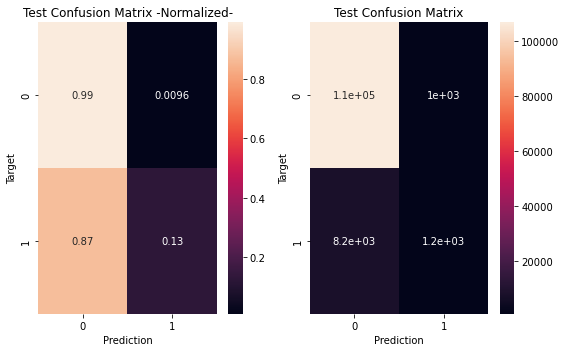

In [204]:
test_preds_LR_3 = search_modelLR_3.predict(X_test[fs_3])
plot_utils.predict_and_plot(test_preds_LR_3, y_test, 'Test')
acc = search_modelLR_3.score(X_test[fs_3], y_test)
rec = recall_score(y_true=y_test, y_pred=test_preds_LR_3)
f1 = f1_score(y_true=y_test, y_pred=test_preds_LR_3)

<ipython-input-205-1b46dd4affb4>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


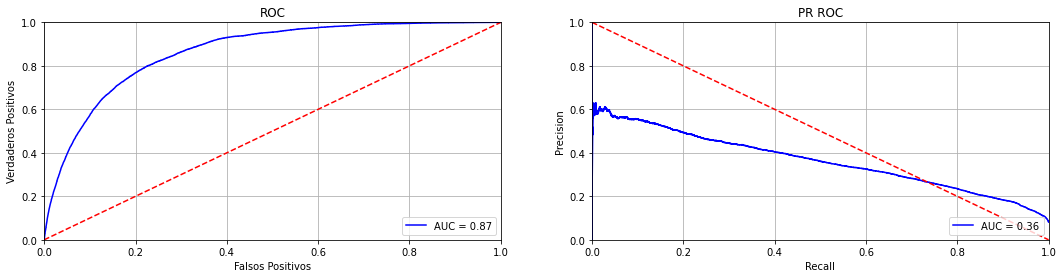

In [205]:
y_pred_LR_3 = search_modelLR_3.predict_proba(X_test[fs_3])

preds_LR_3 = y_pred_LR_3[:,1]

fpr, tpr, threshold = roc_curve(y_test, preds_LR_3)
roc_auc_LR_3 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_LR_3)
pr_roc_auc_LR_3 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_LR_3)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_LR_3)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [206]:
results['modelLR_3'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_LR_3, 'prc': pr_roc_auc_LR_3, 'params': search_modelLR_3.best_params_}
results['modelLR_3']

{'acc': 0.9213619434858373,
 'rec': 0.12790697674418605,
 'f1': 0.20665287831782148,
 'auc': 0.8650291628261916,
 'prc': 0.3631790982875099,
 'params': {'classifier__C': 1.0, 'classifier__penalty': 'l2'}}

#### 6.2.2 Random forest

In [275]:
param_grid_RF = {
    'classifier__n_estimators': [10, 20, 50, 100], 
    'classifier__max_depth': [None, 10, 20],
}

___

In [214]:
modelRF_0 = Pipeline(steps=[('preprocessor', preprocessor_0),
                       ('classifier', RandomForestClassifier(criterion='entropy', random_state=0))])

In [215]:
search_modelRF_0 = GridSearchCV(modelRF_0, param_grid_RF)

with mlflow.start_run(run_name='modelRF_0') as run_modelRF_0:
    search_modelRF_0.fit(X_train[fs_0], y_train)

2022/04/18 01:02:21 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler(...`
2022/04/18 01:29:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer column

Accuracy: 92.22%


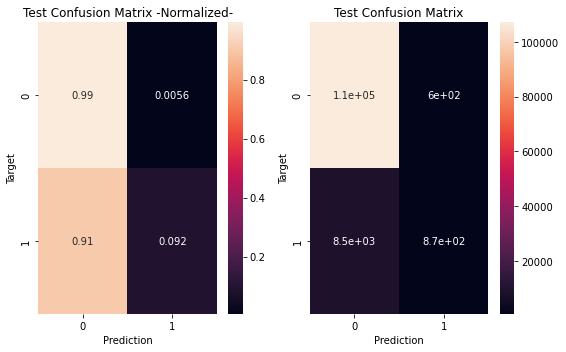

In [217]:
test_preds_RF_0 = search_modelRF_0.predict(X_test[fs_0])
plot_utils.predict_and_plot(test_preds_RF_0, y_test, 'Test')
acc = search_modelRF_0.score(X_test[fs_0], y_test)
rec = recall_score(y_true=y_test, y_pred=test_preds_RF_0)
f1 = f1_score(y_true=y_test, y_pred=test_preds_RF_0)

<ipython-input-218-858bd70cd964>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


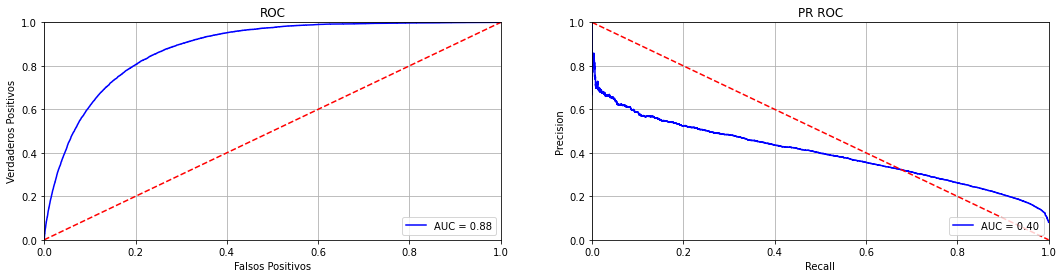

In [218]:
y_pred_RF_0 = search_modelRF_0.predict_proba(X_test[fs_0])

preds_RF_0 = y_pred_RF_0[:,1]

fpr, tpr, threshold = roc_curve(y_test, preds_RF_0)
roc_auc_RF_0 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_RF_0)
pr_roc_auc_RF_0 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_RF_0)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_RF_0)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [219]:
results['modelRF_0'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_RF_0, 'prc': pr_roc_auc_RF_0, 'params': search_modelRF_0.best_params_}
results['modelRF_0']

{'acc': 0.922224689923805,
 'rec': 0.09248986558566247,
 'f1': 0.1599778577359535,
 'auc': 0.8843187241090985,
 'prc': 0.39890063253117547,
 'params': {'classifier__max_depth': 20, 'classifier__n_estimators': 100}}

___

In [227]:
modelRF_1 = Pipeline(steps=[('preprocessor', preprocessor_1),
                       ('classifier', RandomForestClassifier(criterion='entropy', random_state=0))])

In [228]:
search_modelRF_1 = GridSearchCV(modelRF_1, param_grid_RF)

with mlflow.start_run(run_name='modelRF_1') as run_modelRF_1:
    search_modelRF_1.fit(X_train[fs_1], y_train)

2022/04/18 01:50:48 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler(...`
2022/04/18 02:17:14 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer column

Accuracy: 92.21%


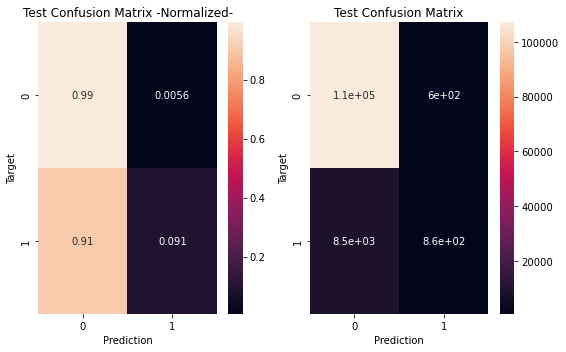

In [229]:
test_preds_RF_1 = search_modelRF_1.predict(X_test[fs_1])
plot_utils.predict_and_plot(test_preds_RF_1, y_test, 'Test')
acc = search_modelRF_1.score(X_test[fs_1], y_test)
rec = recall_score(y_true=y_test, y_pred=test_preds_RF_1)
f1 = f1_score(y_true=y_test, y_pred=test_preds_RF_1)

<ipython-input-230-7ebeb2014054>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


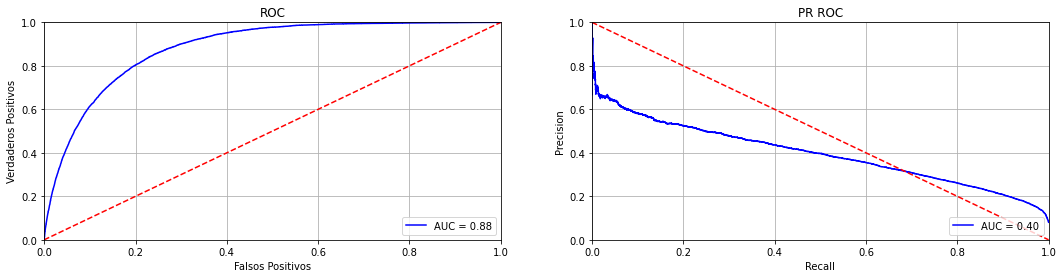

In [230]:
y_pred_RF_1 = search_modelRF_1.predict_proba(X_test[fs_1])

preds_RF_1 = y_pred_RF_1[:,1]

fpr, tpr, threshold = roc_curve(y_test, preds_RF_1)
roc_auc_RF_1 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_RF_1)
pr_roc_auc_RF_1 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_RF_1)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_RF_1)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [231]:
results['modelRF_1'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_RF_1, 'prc': pr_roc_auc_RF_1, 'params': search_modelRF_1.best_params_}
results['modelRF_1']

{'acc': 0.9220880172207606,
 'rec': 0.09142308512908044,
 'f1': 0.15819104753114907,
 'auc': 0.8836028661227198,
 'prc': 0.39592678843116796,
 'params': {'classifier__max_depth': 20, 'classifier__n_estimators': 100}}

___

In [232]:
modelRF_2 = Pipeline(steps=[('preprocessor', preprocessor_2),
                       ('classifier', RandomForestClassifier(criterion='entropy', random_state=0))])

In [233]:
search_modelRF_2 = GridSearchCV(modelRF_2, param_grid_RF)

with mlflow.start_run(run_name='modelRF_2') as run_modelRF_2:
    search_modelRF_2.fit(X_train[fs_2], y_train)

2022/04/18 02:17:34 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler(...`
2022/04/18 02:42:05 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer column

Accuracy: 92.21%


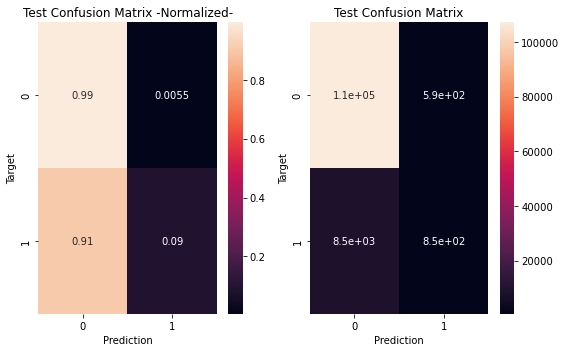

In [234]:
test_preds_RF_2 = search_modelRF_2.predict(X_test[fs_2])
plot_utils.predict_and_plot(test_preds_RF_2, y_test, 'Test')
acc = search_modelRF_2.score(X_test[fs_2], y_test)
rec = recall_score(y_true=y_test, y_pred=test_preds_RF_2)
f1 = f1_score(y_true=y_test, y_pred=test_preds_RF_2)

<ipython-input-235-f7676ab66eb4>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


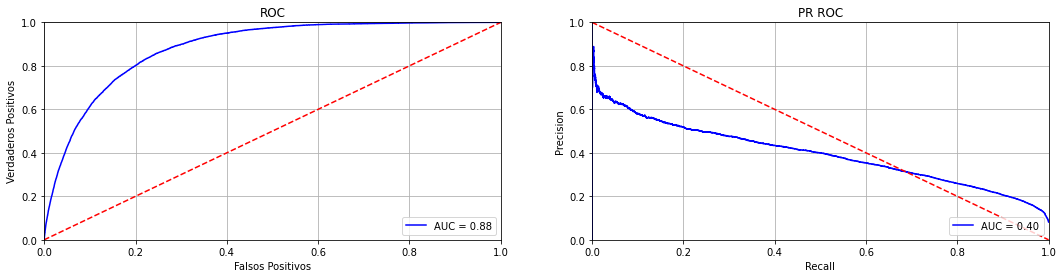

In [235]:
y_pred_RF_2 = search_modelRF_2.predict_proba(X_test[fs_2])

preds_RF_2 = y_pred_RF_2[:,1]

fpr, tpr, threshold = roc_curve(y_test, preds_RF_2)
roc_auc_RF_2 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_RF_2)
pr_roc_auc_RF_2 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_RF_2)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_RF_2)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [236]:
results['modelRF_2'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_RF_2, 'prc': pr_roc_auc_RF_2, 'params': search_modelRF_2.best_params_}
results['modelRF_2']

{'acc': 0.9221478115283425,
 'rec': 0.0904629827181566,
 'f1': 0.1568917668825162,
 'auc': 0.8831692487025038,
 'prc': 0.39540008824236655,
 'params': {'classifier__max_depth': 20, 'classifier__n_estimators': 100}}

___

In [237]:
modelRF_3 = Pipeline(steps=[('preprocessor', preprocessor_3),
                       ('classifier', RandomForestClassifier(criterion='entropy', random_state=0))])

In [238]:
search_modelRF_3 = GridSearchCV(modelRF_3, param_grid_RF)

with mlflow.start_run(run_name='modelRF_3') as run_modelRF_3:
    search_modelRF_3.fit(X_train[fs_3], y_train)

2022/04/18 02:42:24 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler(...`
2022/04/18 03:07:06 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer column

Accuracy: 92.23%


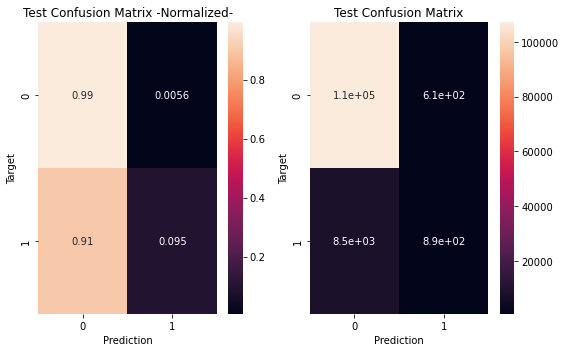

In [239]:
test_preds_RF_3 = search_modelRF_3.predict(X_test[fs_3])
plot_utils.predict_and_plot(test_preds_RF_3, y_test, 'Test')
acc = search_modelRF_3.score(X_test[fs_3], y_test)
rec = recall_score(y_true=y_test, y_pred=test_preds_RF_3)
f1 = f1_score(y_true=y_test, y_pred=test_preds_RF_3)

<ipython-input-240-de733cf54038>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


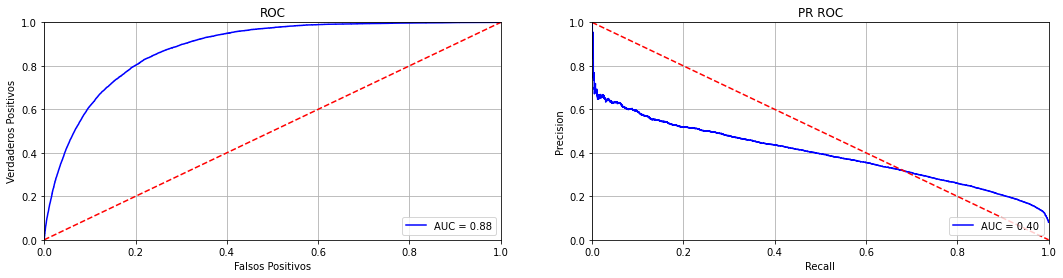

In [240]:
y_pred_RF_3 = search_modelRF_3.predict_proba(X_test[fs_3])

preds_RF_3 = y_pred_RF_3[:,1]

fpr, tpr, threshold = roc_curve(y_test, preds_RF_3)
roc_auc_RF_3 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_RF_3)
pr_roc_auc_RF_3 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_RF_3)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_RF_3)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [241]:
results['modelRF_3'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_RF_3, 'prc': pr_roc_auc_RF_3, 'params': search_modelRF_3.best_params_}
results['modelRF_3']

{'acc': 0.9223271944510882,
 'rec': 0.09483678259014294,
 'f1': 0.16355441081777206,
 'auc': 0.8827676354884383,
 'prc': 0.39517283811851983,
 'params': {'classifier__max_depth': 20, 'classifier__n_estimators': 100}}

#### 6.2.3 Neural Network

In [248]:
param_grid_NN = {
    'classifier__learning_rate_init': [0.01, 0.05, 0.1],
    'classifier__hidden_layer_sizes': [(32, 8, 2), (16, 16)],
}

___

In [249]:
modelNN_0 = Pipeline(steps=[
    ('preprocessor', preprocessor_0),
    ('classifier', MLPClassifier(verbose=True, batch_size=512, activation='relu', solver='adam', max_iter=10, alpha=0.001, random_state=0))
])

In [327]:
search_modelNN_0 = GridSearchCV(modelNN_0, param_grid_NN)

with mlflow.start_run(run_name='modelNN_0_bis') as run_modelNN_0:
    search_modelNN_0.fit(X_train[fs_0], y_train)

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

    

    # Model registry does not work with file store
    if tracking_url_type_store != "file":

        # Register the model
        # There are other ways to use the Model Registry, which depends on the use case,
        # please refer to the doc for more information:
        # https://mlflow.org/docs/latest/model-registry.html#api-workflow
        mlflow.sklearn.log_model(search_modelNN_0, "model", registered_model_name="modelNN_0_bis")
    else:
        mlflow.sklearn.log_model(search_modelNN_0, "model")

2022/04/20 19:55:37 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler(...`


Iteration 1, loss = 0.20806287
Iteration 2, loss = 0.20019225
Iteration 3, loss = 0.19947694
Iteration 4, loss = 0.19888257
Iteration 5, loss = 0.19840892
Iteration 6, loss = 0.19805527
Iteration 7, loss = 0.19836494
Iteration 8, loss = 0.19811260
Iteration 9, loss = 0.19764956
Iteration 10, loss = 0.19895451


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.20663720
Iteration 2, loss = 0.20074999
Iteration 3, loss = 0.19927890
Iteration 4, loss = 0.19851748
Iteration 5, loss = 0.19854104
Iteration 6, loss = 0.19856179
Iteration 7, loss = 0.19811197
Iteration 8, loss = 0.19822614
Iteration 9, loss = 0.19793913
Iteration 10, loss = 0.19852384


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.20693238
Iteration 2, loss = 0.20167265
Iteration 3, loss = 0.19963979
Iteration 4, loss = 0.19865683
Iteration 5, loss = 0.19922099
Iteration 6, loss = 0.19871431
Iteration 7, loss = 0.19839529
Iteration 8, loss = 0.19839343
Iteration 9, loss = 0.19832830
Iteration 10, loss = 0.19865620


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.20822497
Iteration 2, loss = 0.20162882
Iteration 3, loss = 0.20119003
Iteration 4, loss = 0.19982368
Iteration 5, loss = 0.20049463
Iteration 6, loss = 0.19931466
Iteration 7, loss = 0.19913408
Iteration 8, loss = 0.19929409
Iteration 9, loss = 0.19833720
Iteration 10, loss = 0.19924208


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.20832802
Iteration 2, loss = 0.20065461
Iteration 3, loss = 0.20017158
Iteration 4, loss = 0.20003271
Iteration 5, loss = 0.19973901
Iteration 6, loss = 0.19963417
Iteration 7, loss = 0.19948299
Iteration 8, loss = 0.19915628
Iteration 9, loss = 0.19881904
Iteration 10, loss = 0.19854426


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.20960802
Iteration 2, loss = 0.20522742
Iteration 3, loss = 0.20597380
Iteration 4, loss = 0.21315441
Iteration 5, loss = 0.20518924
Iteration 6, loss = 0.20560346
Iteration 7, loss = 0.20523982
Iteration 8, loss = 0.20611507
Iteration 9, loss = 0.20633526
Iteration 10, loss = 0.20416765


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21007896
Iteration 2, loss = 0.20471759
Iteration 3, loss = 0.20570442
Iteration 4, loss = 0.20422519
Iteration 5, loss = 0.20452300
Iteration 6, loss = 0.20530901
Iteration 7, loss = 0.20494351
Iteration 8, loss = 0.20437418
Iteration 9, loss = 0.20343386
Iteration 10, loss = 0.20509048


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21206588
Iteration 2, loss = 0.20651885
Iteration 3, loss = 0.20452723
Iteration 4, loss = 0.20564317
Iteration 5, loss = 0.20566384
Iteration 6, loss = 0.20464079
Iteration 7, loss = 0.20452148
Iteration 8, loss = 0.20596573
Iteration 9, loss = 0.20478064
Iteration 10, loss = 0.20392762


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21297481
Iteration 2, loss = 0.20804544
Iteration 3, loss = 0.20696786
Iteration 4, loss = 0.20520656
Iteration 5, loss = 0.20533981
Iteration 6, loss = 0.20416335
Iteration 7, loss = 0.20463201
Iteration 8, loss = 0.20517172
Iteration 9, loss = 0.20454012
Iteration 10, loss = 0.20373164


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21377820
Iteration 2, loss = 0.20906568
Iteration 3, loss = 0.21068745
Iteration 4, loss = 0.20866590
Iteration 5, loss = 0.20911363
Iteration 6, loss = 0.20791217
Iteration 7, loss = 0.20795234
Iteration 8, loss = 0.20687684
Iteration 9, loss = 0.20724764
Iteration 10, loss = 0.20756685


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.22352487
Iteration 2, loss = 0.21498298
Iteration 3, loss = 0.20957741
Iteration 4, loss = 0.20957097
Iteration 5, loss = 0.20967359
Iteration 6, loss = 0.21044274
Iteration 7, loss = 0.20887867
Iteration 8, loss = 0.20734764
Iteration 9, loss = 0.20729995
Iteration 10, loss = 0.20766018


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.22307712
Iteration 2, loss = 0.22120869
Iteration 3, loss = 0.21496977
Iteration 4, loss = 0.20911372
Iteration 5, loss = 0.20792703
Iteration 6, loss = 0.20829110
Iteration 7, loss = 0.20942443
Iteration 8, loss = 0.20893717
Iteration 9, loss = 0.20791897
Iteration 10, loss = 0.20783410


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21725278
Iteration 2, loss = 0.21108664
Iteration 3, loss = 0.20934783
Iteration 4, loss = 0.20866298
Iteration 5, loss = 0.20706303
Iteration 6, loss = 0.20684405
Iteration 7, loss = 0.20748589
Iteration 8, loss = 0.20638929
Iteration 9, loss = 0.20789425
Iteration 10, loss = 0.20814311


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.22083812
Iteration 2, loss = 0.21575144
Iteration 3, loss = 0.21150297
Iteration 4, loss = 0.22105716
Iteration 5, loss = 0.21138341
Iteration 6, loss = 0.21049399
Iteration 7, loss = 0.20977633
Iteration 8, loss = 0.20958607
Iteration 9, loss = 0.20897863
Iteration 10, loss = 0.21078981


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21762281
Iteration 2, loss = 0.21621400
Iteration 3, loss = 0.21120068
Iteration 4, loss = 0.20919411
Iteration 5, loss = 0.20722313
Iteration 6, loss = 0.20802713
Iteration 7, loss = 0.20783532
Iteration 8, loss = 0.20930580
Iteration 9, loss = 0.20790970
Iteration 10, loss = 0.21290212


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.22289707
Iteration 2, loss = 0.20113612
Iteration 3, loss = 0.20054728
Iteration 4, loss = 0.19889122
Iteration 5, loss = 0.19886320
Iteration 6, loss = 0.19962028
Iteration 7, loss = 0.19895794
Iteration 8, loss = 0.19814844
Iteration 9, loss = 0.19829570
Iteration 10, loss = 0.19795325


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.22615412
Iteration 2, loss = 0.20106376
Iteration 3, loss = 0.19958482
Iteration 4, loss = 0.19937247
Iteration 5, loss = 0.19931232
Iteration 6, loss = 0.19846330
Iteration 7, loss = 0.19806842
Iteration 8, loss = 0.19822837
Iteration 9, loss = 0.19798722
Iteration 10, loss = 0.19796844


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21917045
Iteration 2, loss = 0.20099955
Iteration 3, loss = 0.20119527
Iteration 4, loss = 0.19980350
Iteration 5, loss = 0.19868802
Iteration 6, loss = 0.19913290
Iteration 7, loss = 0.19856402
Iteration 8, loss = 0.19898856
Iteration 9, loss = 0.19825536
Iteration 10, loss = 0.19920292


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21912707
Iteration 2, loss = 0.20119480
Iteration 3, loss = 0.20071939
Iteration 4, loss = 0.20018943
Iteration 5, loss = 0.19989372
Iteration 6, loss = 0.20047835
Iteration 7, loss = 0.19956066
Iteration 8, loss = 0.19949122
Iteration 9, loss = 0.19955035
Iteration 10, loss = 0.19985059


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21928646
Iteration 2, loss = 0.20218937
Iteration 3, loss = 0.20026801
Iteration 4, loss = 0.19949645
Iteration 5, loss = 0.19924428
Iteration 6, loss = 0.19891581
Iteration 7, loss = 0.19909088
Iteration 8, loss = 0.19877289
Iteration 9, loss = 0.19888131
Iteration 10, loss = 0.19885040


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21254274
Iteration 2, loss = 0.20478624
Iteration 3, loss = 0.20459807
Iteration 4, loss = 0.20306002
Iteration 5, loss = 0.20320288
Iteration 6, loss = 0.20270643
Iteration 7, loss = 0.20353383
Iteration 8, loss = 0.20229815
Iteration 9, loss = 0.20431289
Iteration 10, loss = 0.20258304


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21741287
Iteration 2, loss = 0.20298015
Iteration 3, loss = 0.20347784
Iteration 4, loss = 0.20286308
Iteration 5, loss = 0.20470742
Iteration 6, loss = 0.20352087
Iteration 7, loss = 0.20276596
Iteration 8, loss = 0.20255492
Iteration 9, loss = 0.20266350
Iteration 10, loss = 0.20272244


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21290811
Iteration 2, loss = 0.20509421
Iteration 3, loss = 0.20424563
Iteration 4, loss = 0.20347337
Iteration 5, loss = 0.20284017
Iteration 6, loss = 0.20355306
Iteration 7, loss = 0.20373317
Iteration 8, loss = 0.20386436
Iteration 9, loss = 0.20390181
Iteration 10, loss = 0.20330496


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21242452
Iteration 2, loss = 0.20737095
Iteration 3, loss = 0.20601590
Iteration 4, loss = 0.20567970
Iteration 5, loss = 0.20610330
Iteration 6, loss = 0.20341688
Iteration 7, loss = 0.20401621
Iteration 8, loss = 0.20315060
Iteration 9, loss = 0.20640564
Iteration 10, loss = 0.20664229


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21171578
Iteration 2, loss = 0.20552659
Iteration 3, loss = 0.20536690
Iteration 4, loss = 0.20617874
Iteration 5, loss = 0.20527193
Iteration 6, loss = 0.20473347
Iteration 7, loss = 0.20401894
Iteration 8, loss = 0.20331311
Iteration 9, loss = 0.20489990
Iteration 10, loss = 0.20434977


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21367395
Iteration 2, loss = 0.20967086
Iteration 3, loss = 0.20786730
Iteration 4, loss = 0.20839882
Iteration 5, loss = 0.21130564
Iteration 6, loss = 0.20879664
Iteration 7, loss = 0.20865194
Iteration 8, loss = 0.21035106
Iteration 9, loss = 0.24586999
Iteration 10, loss = 0.28066230


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21803024
Iteration 2, loss = 0.20971643
Iteration 3, loss = 0.20653746
Iteration 4, loss = 0.20598857
Iteration 5, loss = 0.20621267
Iteration 6, loss = 0.20740253
Iteration 7, loss = 0.20665500
Iteration 8, loss = 0.20920526
Iteration 9, loss = 0.20854943
Iteration 10, loss = 0.20660169


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21382359
Iteration 2, loss = 0.20846301
Iteration 3, loss = 0.20950124
Iteration 4, loss = 0.20624689
Iteration 5, loss = 0.20661110
Iteration 6, loss = 0.20751461
Iteration 7, loss = 0.20641018
Iteration 8, loss = 0.20632261
Iteration 9, loss = 0.20978295
Iteration 10, loss = 0.20716327


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21281967
Iteration 2, loss = 0.20886961
Iteration 3, loss = 0.20905061
Iteration 4, loss = 0.20970183
Iteration 5, loss = 0.20853677
Iteration 6, loss = 0.20989473
Iteration 7, loss = 0.20898715
Iteration 8, loss = 0.20765078
Iteration 9, loss = 0.20815004
Iteration 10, loss = 0.20656325


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21222853
Iteration 2, loss = 0.20701263
Iteration 3, loss = 0.20896361
Iteration 4, loss = 0.20870579
Iteration 5, loss = 0.20927680
Iteration 6, loss = 0.21278725
Iteration 7, loss = 0.20976231
Iteration 8, loss = 0.20794119
Iteration 9, loss = 0.21141279
Iteration 10, loss = 0.20918872


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.22006614
Iteration 2, loss = 0.20025075
Iteration 3, loss = 0.20043739
Iteration 4, loss = 0.19929847
Iteration 5, loss = 0.19971147
Iteration 6, loss = 0.19876617
Iteration 7, loss = 0.19843071
Iteration 8, loss = 0.19885508
Iteration 9, loss = 0.19843976
Iteration 10, loss = 0.19876069


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
2022/04/20 20:00:20 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing

In [251]:
print("Best parameter (CV score=%0.3f):" % search_modelNN_0.best_score_)
print(search_modelNN_0.best_params_)

Best parameter (CV score=0.920):
{'classifier__hidden_layer_sizes': (16, 16), 'classifier__learning_rate_init': 0.01}


Accuracy: 91.99%


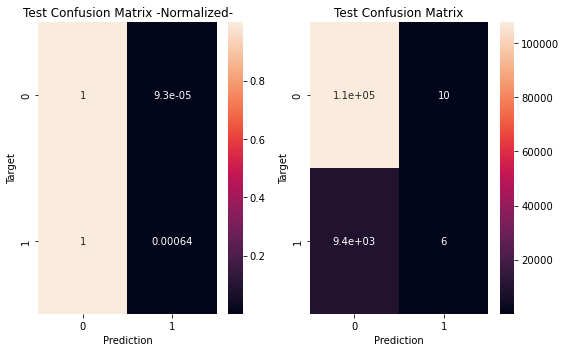

In [252]:
test_preds_NN_0 = search_modelNN_0.predict(X_test[fs_0])
plot_utils.predict_and_plot(test_preds_NN_0, y_test, 'Test')
acc = search_modelNN_0.score(X_test[fs_0], y_test)
rec = recall_score(y_true=y_test, y_pred=test_preds_NN_0)
f1 = f1_score(y_true=y_test, y_pred=test_preds_NN_0)

<ipython-input-253-8d37cf1bf8b2>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


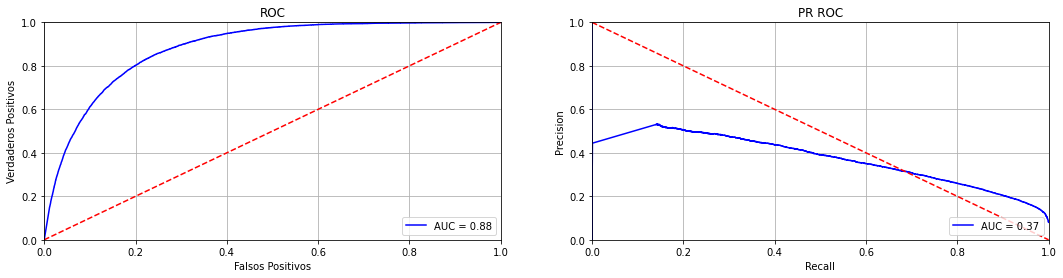

In [253]:
y_pred_NN_0 = search_modelNN_0.predict_proba(X_test[fs_0])

preds_NN_0 = y_pred_NN_0[:,1]

fpr, tpr, threshold = roc_curve(y_test, preds_NN_0)
roc_auc_NN_0 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_NN_0)
pr_roc_auc_NN_0 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_NN_0)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_NN_0)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [254]:
results['modelNN_0'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_NN_0, 'prc': pr_roc_auc_NN_0, 'params': search_modelNN_0.best_params_}
results['modelNN_0']

{'acc': 0.9198927119281102,
 'rec': 0.0006400682739492212,
 'f1': 0.001277955271565495,
 'auc': 0.882110887564074,
 'prc': 0.37361068443115397,
 'params': {'classifier__hidden_layer_sizes': (16, 16),
  'classifier__learning_rate_init': 0.01}}

___

In [255]:
modelNN_1 = Pipeline(steps=[
    ('preprocessor', preprocessor_1),
    ('classifier', MLPClassifier(verbose=True, batch_size=512, activation='relu', solver='adam', max_iter=10, alpha=0.001, random_state=0))
])

In [256]:
search_modelNN_1 = GridSearchCV(modelNN_1, param_grid_NN)

with mlflow.start_run(run_name='modelNN_1') as run_modelNN_1:
    search_modelNN_1.fit(X_train[fs_1], y_train)


2022/04/18 09:30:35 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler(...`


Iteration 1, loss = 0.21615913
Iteration 2, loss = 0.20205411
Iteration 3, loss = 0.19975921
Iteration 4, loss = 0.19883085
Iteration 5, loss = 0.19895921
Iteration 6, loss = 0.19810156
Iteration 7, loss = 0.19791274
Iteration 8, loss = 0.19783645
Iteration 9, loss = 0.19790776
Iteration 10, loss = 0.19753710


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21530236
Iteration 2, loss = 0.20103186
Iteration 3, loss = 0.19912024
Iteration 4, loss = 0.19900069
Iteration 5, loss = 0.19828603
Iteration 6, loss = 0.19786535
Iteration 7, loss = 0.19868803
Iteration 8, loss = 0.19765938
Iteration 9, loss = 0.19754601
Iteration 10, loss = 0.19758300


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21614596
Iteration 2, loss = 0.20132926
Iteration 3, loss = 0.19947866
Iteration 4, loss = 0.19924289
Iteration 5, loss = 0.19916550
Iteration 6, loss = 0.19860099
Iteration 7, loss = 0.19846193
Iteration 8, loss = 0.19852103
Iteration 9, loss = 0.19811152
Iteration 10, loss = 0.19818761


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21575138
Iteration 2, loss = 0.20168436
Iteration 3, loss = 0.20083799
Iteration 4, loss = 0.20240954
Iteration 5, loss = 0.20038717
Iteration 6, loss = 0.19966522
Iteration 7, loss = 0.19995004
Iteration 8, loss = 0.20012317
Iteration 9, loss = 0.19921250
Iteration 10, loss = 0.19906839


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21604226
Iteration 2, loss = 0.20177631
Iteration 3, loss = 0.19974199
Iteration 4, loss = 0.19896627
Iteration 5, loss = 0.19918639
Iteration 6, loss = 0.19946266
Iteration 7, loss = 0.20044812
Iteration 8, loss = 0.19975568
Iteration 9, loss = 0.19957657
Iteration 10, loss = 0.19942021


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21509686
Iteration 2, loss = 0.20593666
Iteration 3, loss = 0.20488788
Iteration 4, loss = 0.20450477
Iteration 5, loss = 0.20396403
Iteration 6, loss = 0.20511370
Iteration 7, loss = 0.20585372
Iteration 8, loss = 0.20327312
Iteration 9, loss = 0.20377834
Iteration 10, loss = 0.20326760


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21410909
Iteration 2, loss = 0.20550395
Iteration 3, loss = 0.20650649
Iteration 4, loss = 0.20776331
Iteration 5, loss = 0.20588335
Iteration 6, loss = 0.20764047
Iteration 7, loss = 0.20548652
Iteration 8, loss = 0.20485743
Iteration 9, loss = 0.20656793
Iteration 10, loss = 0.20518191


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21211294
Iteration 2, loss = 0.20596372
Iteration 3, loss = 0.20516186
Iteration 4, loss = 0.20535025
Iteration 5, loss = 0.20580511
Iteration 6, loss = 0.20516534
Iteration 7, loss = 0.20654887
Iteration 8, loss = 0.20712319
Iteration 9, loss = 0.20553808
Iteration 10, loss = 0.20699829


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21134399
Iteration 2, loss = 0.20610206
Iteration 3, loss = 0.20498737
Iteration 4, loss = 0.20495054
Iteration 5, loss = 0.20595389
Iteration 6, loss = 0.20537993
Iteration 7, loss = 0.20492846
Iteration 8, loss = 0.20660267
Iteration 9, loss = 0.20800827
Iteration 10, loss = 0.20666224


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21103297
Iteration 2, loss = 0.20661425
Iteration 3, loss = 0.20523559
Iteration 4, loss = 0.20512721
Iteration 5, loss = 0.20416206
Iteration 6, loss = 0.20553025
Iteration 7, loss = 0.20400165
Iteration 8, loss = 0.20466682
Iteration 9, loss = 0.20852237
Iteration 10, loss = 0.20587117


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21658925
Iteration 2, loss = 0.21366706
Iteration 3, loss = 0.21480417
Iteration 4, loss = 0.21192411
Iteration 5, loss = 0.20914058
Iteration 6, loss = 0.21023448
Iteration 7, loss = 0.21022497
Iteration 8, loss = 0.20782921
Iteration 9, loss = 0.20679346
Iteration 10, loss = 0.20855624


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21861539
Iteration 2, loss = 0.21431704
Iteration 3, loss = 0.21217276
Iteration 4, loss = 0.20840269
Iteration 5, loss = 0.20872654
Iteration 6, loss = 0.20740909
Iteration 7, loss = 0.21033692
Iteration 8, loss = 0.20669715
Iteration 9, loss = 0.20815117
Iteration 10, loss = 0.20801908


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.22054623
Iteration 2, loss = 0.21319698
Iteration 3, loss = 0.21094062
Iteration 4, loss = 0.20838566
Iteration 5, loss = 0.20868611
Iteration 6, loss = 0.20793562
Iteration 7, loss = 0.20791112
Iteration 8, loss = 0.20705961
Iteration 9, loss = 0.20856259
Iteration 10, loss = 0.20706468


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21386377
Iteration 2, loss = 0.21313386
Iteration 3, loss = 0.20974653
Iteration 4, loss = 0.21057925
Iteration 5, loss = 0.21038466
Iteration 6, loss = 0.20946611
Iteration 7, loss = 0.20781457
Iteration 8, loss = 0.20730791
Iteration 9, loss = 0.20696509
Iteration 10, loss = 0.20755761


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21886519
Iteration 2, loss = 0.21406898
Iteration 3, loss = 0.22463775
Iteration 4, loss = 0.22642405
Iteration 5, loss = 0.24480232
Iteration 6, loss = 0.24148319
Iteration 7, loss = 0.24681418
Iteration 8, loss = 0.23978792
Iteration 9, loss = 0.24617954
Iteration 10, loss = 0.24974078


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21539050
Iteration 2, loss = 0.20146138
Iteration 3, loss = 0.19987990
Iteration 4, loss = 0.19939893
Iteration 5, loss = 0.19892714
Iteration 6, loss = 0.19959645
Iteration 7, loss = 0.19895939
Iteration 8, loss = 0.19838974
Iteration 9, loss = 0.19847722
Iteration 10, loss = 0.19806600


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21784082
Iteration 2, loss = 0.20069266
Iteration 3, loss = 0.19998561
Iteration 4, loss = 0.19948392
Iteration 5, loss = 0.19848711
Iteration 6, loss = 0.19861299
Iteration 7, loss = 0.19951589
Iteration 8, loss = 0.19864042
Iteration 9, loss = 0.19846095
Iteration 10, loss = 0.19808511


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21667073
Iteration 2, loss = 0.20151411
Iteration 3, loss = 0.20079038
Iteration 4, loss = 0.19987869
Iteration 5, loss = 0.19941107
Iteration 6, loss = 0.19916560
Iteration 7, loss = 0.19986352
Iteration 8, loss = 0.19933216
Iteration 9, loss = 0.19877189
Iteration 10, loss = 0.19948591


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21749924
Iteration 2, loss = 0.20165007
Iteration 3, loss = 0.20131701
Iteration 4, loss = 0.19997814
Iteration 5, loss = 0.19954777
Iteration 6, loss = 0.19892882
Iteration 7, loss = 0.19899137
Iteration 8, loss = 0.19874766
Iteration 9, loss = 0.19863781
Iteration 10, loss = 0.19881178


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21530294
Iteration 2, loss = 0.20199625
Iteration 3, loss = 0.20021805
Iteration 4, loss = 0.19969454
Iteration 5, loss = 0.19943046
Iteration 6, loss = 0.19930230
Iteration 7, loss = 0.19968855
Iteration 8, loss = 0.19900194
Iteration 9, loss = 0.19904614
Iteration 10, loss = 0.19939209


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21068747
Iteration 2, loss = 0.20203815
Iteration 3, loss = 0.20223369
Iteration 4, loss = 0.20346950
Iteration 5, loss = 0.20215608
Iteration 6, loss = 0.20237182
Iteration 7, loss = 0.20279868
Iteration 8, loss = 0.20243112
Iteration 9, loss = 0.20237001
Iteration 10, loss = 0.20295960


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.20950460
Iteration 2, loss = 0.20336214
Iteration 3, loss = 0.20292808
Iteration 4, loss = 0.20289645
Iteration 5, loss = 0.20399602
Iteration 6, loss = 0.20291511
Iteration 7, loss = 0.20525231
Iteration 8, loss = 0.20287618
Iteration 9, loss = 0.20345885
Iteration 10, loss = 0.20301856


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21339784
Iteration 2, loss = 0.20545866
Iteration 3, loss = 0.20411225
Iteration 4, loss = 0.20403345
Iteration 5, loss = 0.20439057
Iteration 6, loss = 0.20416263
Iteration 7, loss = 0.20310547
Iteration 8, loss = 0.20431456
Iteration 9, loss = 0.20326365
Iteration 10, loss = 0.20324276


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21185787
Iteration 2, loss = 0.20597572
Iteration 3, loss = 0.20458308
Iteration 4, loss = 0.20325261
Iteration 5, loss = 0.20573924
Iteration 6, loss = 0.20381510
Iteration 7, loss = 0.20293634
Iteration 8, loss = 0.20731552
Iteration 9, loss = 0.20488128
Iteration 10, loss = 0.20488794


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21125669
Iteration 2, loss = 0.20377772
Iteration 3, loss = 0.20522559
Iteration 4, loss = 0.20440618
Iteration 5, loss = 0.20465821
Iteration 6, loss = 0.20578074
Iteration 7, loss = 0.20443767
Iteration 8, loss = 0.20437950
Iteration 9, loss = 0.20353272
Iteration 10, loss = 0.20315924


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21448654
Iteration 2, loss = 0.21146258
Iteration 3, loss = 0.20678277
Iteration 4, loss = 0.20962766
Iteration 5, loss = 0.20851412
Iteration 6, loss = 0.20619181
Iteration 7, loss = 0.20904451
Iteration 8, loss = 0.20752651
Iteration 9, loss = 0.20747954
Iteration 10, loss = 0.20620836


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21668080
Iteration 2, loss = 0.21419770
Iteration 3, loss = 0.20871716
Iteration 4, loss = 0.20612160
Iteration 5, loss = 0.20769870
Iteration 6, loss = 0.21012656
Iteration 7, loss = 0.20724343
Iteration 8, loss = 0.20596958
Iteration 9, loss = 0.20739099
Iteration 10, loss = 0.20691020


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21437780
Iteration 2, loss = 0.20565570
Iteration 3, loss = 0.20613860
Iteration 4, loss = 0.20909644
Iteration 5, loss = 0.20854432
Iteration 6, loss = 0.20770484
Iteration 7, loss = 0.20788761
Iteration 8, loss = 0.21022223
Iteration 9, loss = 0.20965431
Iteration 10, loss = 0.20899896


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21294004
Iteration 2, loss = 0.20596987
Iteration 3, loss = 0.20733890
Iteration 4, loss = 0.21304109
Iteration 5, loss = 0.21639461
Iteration 6, loss = 0.21799215
Iteration 7, loss = 0.20961443
Iteration 8, loss = 0.21026673
Iteration 9, loss = 0.21182628
Iteration 10, loss = 0.21216559


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21522715
Iteration 2, loss = 0.20805920
Iteration 3, loss = 0.20905472
Iteration 4, loss = 0.20879776
Iteration 5, loss = 0.20826401
Iteration 6, loss = 0.20796563
Iteration 7, loss = 0.20752793
Iteration 8, loss = 0.20767673
Iteration 9, loss = 0.20752736
Iteration 10, loss = 0.20799485


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21433804
Iteration 2, loss = 0.20179523
Iteration 3, loss = 0.20026446
Iteration 4, loss = 0.20005037
Iteration 5, loss = 0.19923178
Iteration 6, loss = 0.19920400
Iteration 7, loss = 0.20043744
Iteration 8, loss = 0.19922922
Iteration 9, loss = 0.19933318
Iteration 10, loss = 0.19897089


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022/04/18 09:35:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a sc

In [257]:
print("Best parameter (CV score=%0.3f):" % search_modelNN_1.best_score_)
print(search_modelNN_1.best_params_)

Best parameter (CV score=0.920):
{'classifier__hidden_layer_sizes': (32, 8, 2), 'classifier__learning_rate_init': 0.01}


Accuracy: 91.99%


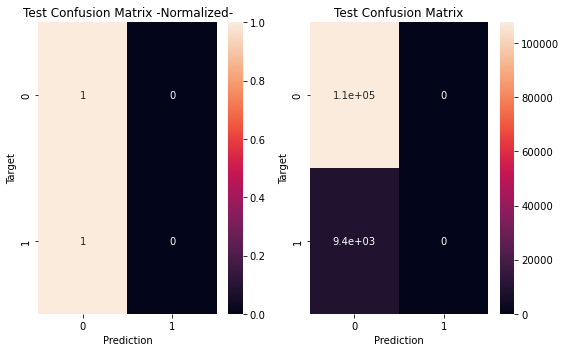

In [258]:
test_preds_NN_1 = search_modelNN_1.predict(X_test[fs_1])
plot_utils.predict_and_plot(test_preds_NN_1, y_test, 'Test')
acc = search_modelNN_1.score(X_test[fs_1], y_test)
rec = recall_score(y_true=y_test, y_pred=test_preds_NN_1)
f1 = f1_score(y_true=y_test, y_pred=test_preds_NN_1)

<ipython-input-259-12771b861024>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


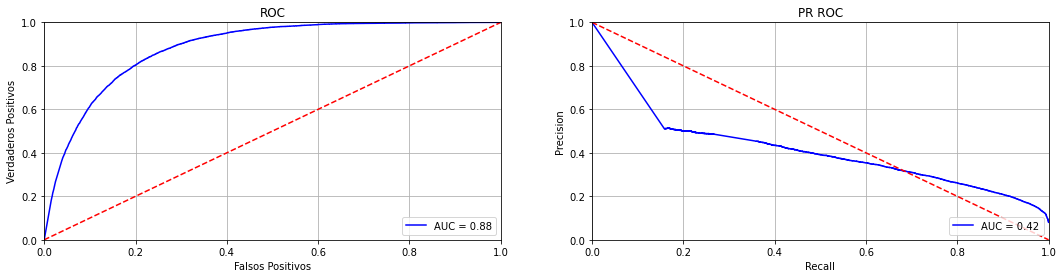

In [259]:
y_pred_NN_1 = search_modelNN_1.predict_proba(X_test[fs_1])

preds_NN_1 = y_pred_NN_1[:,1]

fpr, tpr, threshold = roc_curve(y_test, preds_NN_1)
roc_auc_NN_1 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_NN_1)
pr_roc_auc_NN_1 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_NN_1)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_NN_1)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [260]:
results['modelNN_1'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_NN_1, 'prc': pr_roc_auc_NN_1, 'params': search_modelNN_1.best_params_}
results['modelNN_1']

{'acc': 0.9199268801038712,
 'rec': 0.0,
 'f1': 0.0,
 'auc': 0.8833021341604039,
 'prc': 0.41581955715280927,
 'params': {'classifier__hidden_layer_sizes': (32, 8, 2),
  'classifier__learning_rate_init': 0.01}}

___

In [261]:
modelNN_2 = Pipeline(steps=[
    ('preprocessor', preprocessor_2),
    ('classifier', MLPClassifier(verbose=True, batch_size=512, activation='relu', solver='adam', max_iter=10, alpha=0.001, random_state=0))
])

In [262]:
search_modelNN_2 = GridSearchCV(modelNN_2, param_grid_NN)

with mlflow.start_run(run_name='modelNN_2') as run_modelNN_2:
    search_modelNN_2.fit(X_train[fs_2], y_train)

2022/04/18 09:35:26 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler(...`


Iteration 1, loss = 0.20573146
Iteration 2, loss = 0.19982359
Iteration 3, loss = 0.19861130
Iteration 4, loss = 0.19992797
Iteration 5, loss = 0.19872511
Iteration 6, loss = 0.19824814
Iteration 7, loss = 0.19784955
Iteration 8, loss = 0.19752706
Iteration 9, loss = 0.19745361
Iteration 10, loss = 0.19765562


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.20566698
Iteration 2, loss = 0.19878491
Iteration 3, loss = 0.19792415
Iteration 4, loss = 0.19829677
Iteration 5, loss = 0.19803547
Iteration 6, loss = 0.19783628
Iteration 7, loss = 0.19770574
Iteration 8, loss = 0.19750392
Iteration 9, loss = 0.19708976
Iteration 10, loss = 0.19724943


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.20642505
Iteration 2, loss = 0.20006420
Iteration 3, loss = 0.19870585
Iteration 4, loss = 0.19817923
Iteration 5, loss = 0.19797058
Iteration 6, loss = 0.19780725
Iteration 7, loss = 0.19847499
Iteration 8, loss = 0.19786889
Iteration 9, loss = 0.19746745
Iteration 10, loss = 0.19762935


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.20706924
Iteration 2, loss = 0.20071518
Iteration 3, loss = 0.19946475
Iteration 4, loss = 0.19924196
Iteration 5, loss = 0.19946659
Iteration 6, loss = 0.19895158
Iteration 7, loss = 0.19855867
Iteration 8, loss = 0.19812822
Iteration 9, loss = 0.19796008
Iteration 10, loss = 0.19808822


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.20639351
Iteration 2, loss = 0.20015076
Iteration 3, loss = 0.19874526
Iteration 4, loss = 0.19926711
Iteration 5, loss = 0.19837618
Iteration 6, loss = 0.19802438
Iteration 7, loss = 0.19804556
Iteration 8, loss = 0.19824251
Iteration 9, loss = 0.19800783
Iteration 10, loss = 0.19787822


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.20768665
Iteration 2, loss = 0.20353865
Iteration 3, loss = 0.20277784
Iteration 4, loss = 0.20322761
Iteration 5, loss = 0.20411965
Iteration 6, loss = 0.20374211
Iteration 7, loss = 0.20343186
Iteration 8, loss = 0.20291678
Iteration 9, loss = 0.20268406
Iteration 10, loss = 0.20483438


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.20707413
Iteration 2, loss = 0.20446977
Iteration 3, loss = 0.20233110
Iteration 4, loss = 0.20252213
Iteration 5, loss = 0.20502424
Iteration 6, loss = 0.20460047
Iteration 7, loss = 0.20279398
Iteration 8, loss = 0.20403682
Iteration 9, loss = 0.20317808
Iteration 10, loss = 0.20385432


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.20775525
Iteration 2, loss = 0.20407738
Iteration 3, loss = 0.20611617
Iteration 4, loss = 0.20378637
Iteration 5, loss = 0.20335186
Iteration 6, loss = 0.20414187
Iteration 7, loss = 0.20371575
Iteration 8, loss = 0.20407246
Iteration 9, loss = 0.20488470
Iteration 10, loss = 0.20342639


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21035751
Iteration 2, loss = 0.20676269
Iteration 3, loss = 0.20421205
Iteration 4, loss = 0.20308956
Iteration 5, loss = 0.20574643
Iteration 6, loss = 0.20413101
Iteration 7, loss = 0.20282102
Iteration 8, loss = 0.20409286
Iteration 9, loss = 0.20362467
Iteration 10, loss = 0.20355364


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.20733134
Iteration 2, loss = 0.20526194
Iteration 3, loss = 0.20391926
Iteration 4, loss = 0.20267961
Iteration 5, loss = 0.20279041
Iteration 6, loss = 0.20400363
Iteration 7, loss = 0.20346700
Iteration 8, loss = 0.20375759
Iteration 9, loss = 0.20417379
Iteration 10, loss = 0.20351808


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.20991505
Iteration 2, loss = 0.20728085
Iteration 3, loss = 0.20764811
Iteration 4, loss = 0.20704333
Iteration 5, loss = 0.20698147
Iteration 6, loss = 0.20608629
Iteration 7, loss = 0.20818369
Iteration 8, loss = 0.20603465
Iteration 9, loss = 0.21094077
Iteration 10, loss = 0.20802548


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21252590
Iteration 2, loss = 0.20672136
Iteration 3, loss = 0.20722129
Iteration 4, loss = 0.20571955
Iteration 5, loss = 0.20730741
Iteration 6, loss = 0.20557750
Iteration 7, loss = 0.20582543
Iteration 8, loss = 0.20752724
Iteration 9, loss = 0.20562082
Iteration 10, loss = 0.20689073


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21096004
Iteration 2, loss = 0.20612135
Iteration 3, loss = 0.20773731
Iteration 4, loss = 0.20611135
Iteration 5, loss = 0.20658190
Iteration 6, loss = 0.20700666
Iteration 7, loss = 0.20757561
Iteration 8, loss = 0.20520632
Iteration 9, loss = 0.20840223
Iteration 10, loss = 0.20585129


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21107312
Iteration 2, loss = 0.20739235
Iteration 3, loss = 0.21022787
Iteration 4, loss = 0.20853517
Iteration 5, loss = 0.20567977
Iteration 6, loss = 0.20585990
Iteration 7, loss = 0.21083444
Iteration 8, loss = 0.20904885
Iteration 9, loss = 0.21194685
Iteration 10, loss = 0.20969821


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21021744
Iteration 2, loss = 0.20560756
Iteration 3, loss = 0.20836387
Iteration 4, loss = 0.21297686
Iteration 5, loss = 0.20734072
Iteration 6, loss = 0.20621380
Iteration 7, loss = 0.20548001
Iteration 8, loss = 0.20590471
Iteration 9, loss = 0.20821600
Iteration 10, loss = 0.20644244


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21324688
Iteration 2, loss = 0.20081538
Iteration 3, loss = 0.19890282
Iteration 4, loss = 0.19822587
Iteration 5, loss = 0.19845782
Iteration 6, loss = 0.19800631
Iteration 7, loss = 0.19823549
Iteration 8, loss = 0.19781384
Iteration 9, loss = 0.19804073
Iteration 10, loss = 0.19859971


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21085859
Iteration 2, loss = 0.19984364
Iteration 3, loss = 0.19940730
Iteration 4, loss = 0.19883988
Iteration 5, loss = 0.19863217
Iteration 6, loss = 0.19838847
Iteration 7, loss = 0.19812388
Iteration 8, loss = 0.19867822
Iteration 9, loss = 0.19851139
Iteration 10, loss = 0.19840657


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21102768
Iteration 2, loss = 0.20106347
Iteration 3, loss = 0.19942016
Iteration 4, loss = 0.19905793
Iteration 5, loss = 0.19856101
Iteration 6, loss = 0.19844442
Iteration 7, loss = 0.19809031
Iteration 8, loss = 0.19808622
Iteration 9, loss = 0.19780918
Iteration 10, loss = 0.19805702


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21360451
Iteration 2, loss = 0.20011919
Iteration 3, loss = 0.19984100
Iteration 4, loss = 0.19942822
Iteration 5, loss = 0.19885991
Iteration 6, loss = 0.19855385
Iteration 7, loss = 0.19960643
Iteration 8, loss = 0.19957864
Iteration 9, loss = 0.19841081
Iteration 10, loss = 0.19909640


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21261501
Iteration 2, loss = 0.20002293
Iteration 3, loss = 0.19973795
Iteration 4, loss = 0.19897007
Iteration 5, loss = 0.19965491
Iteration 6, loss = 0.19884135
Iteration 7, loss = 0.19866167
Iteration 8, loss = 0.19859674
Iteration 9, loss = 0.19846820
Iteration 10, loss = 0.19869438


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.20956044
Iteration 2, loss = 0.20145952
Iteration 3, loss = 0.20317778
Iteration 4, loss = 0.20150991
Iteration 5, loss = 0.20154080
Iteration 6, loss = 0.20138391
Iteration 7, loss = 0.20133018
Iteration 8, loss = 0.20333698
Iteration 9, loss = 0.20299079
Iteration 10, loss = 0.20241724


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21012829
Iteration 2, loss = 0.20290717
Iteration 3, loss = 0.20304621
Iteration 4, loss = 0.20427343
Iteration 5, loss = 0.20286445
Iteration 6, loss = 0.20222970
Iteration 7, loss = 0.20258700
Iteration 8, loss = 0.20346351
Iteration 9, loss = 0.20189031
Iteration 10, loss = 0.20252666


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.20883609
Iteration 2, loss = 0.20348626
Iteration 3, loss = 0.20289690
Iteration 4, loss = 0.20239527
Iteration 5, loss = 0.20433026
Iteration 6, loss = 0.20295705
Iteration 7, loss = 0.20297007
Iteration 8, loss = 0.20838337
Iteration 9, loss = 0.20647603
Iteration 10, loss = 0.20423345


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21003574
Iteration 2, loss = 0.20348294
Iteration 3, loss = 0.20345563
Iteration 4, loss = 0.20242199
Iteration 5, loss = 0.20289336
Iteration 6, loss = 0.20335865
Iteration 7, loss = 0.20403463
Iteration 8, loss = 0.20350936
Iteration 9, loss = 0.20421488
Iteration 10, loss = 0.20501935


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.20937490
Iteration 2, loss = 0.20568770
Iteration 3, loss = 0.20352360
Iteration 4, loss = 0.20468228
Iteration 5, loss = 0.20277702
Iteration 6, loss = 0.20371019
Iteration 7, loss = 0.20311735
Iteration 8, loss = 0.20288958
Iteration 9, loss = 0.20508929
Iteration 10, loss = 0.20447330


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21017356
Iteration 2, loss = 0.21330974
Iteration 3, loss = 0.20507395
Iteration 4, loss = 0.20371097
Iteration 5, loss = 0.20945322
Iteration 6, loss = 0.20744330
Iteration 7, loss = 0.20510791
Iteration 8, loss = 0.20619211
Iteration 9, loss = 0.20878885
Iteration 10, loss = 0.21043344


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21005532
Iteration 2, loss = 0.20512283
Iteration 3, loss = 0.20644954
Iteration 4, loss = 0.20809225
Iteration 5, loss = 0.20655530
Iteration 6, loss = 0.20634676
Iteration 7, loss = 0.20552391
Iteration 8, loss = 0.20702738
Iteration 9, loss = 0.20640247
Iteration 10, loss = 0.20794474


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.20999788
Iteration 2, loss = 0.20547867
Iteration 3, loss = 0.20755537
Iteration 4, loss = 0.20586897
Iteration 5, loss = 0.20577368
Iteration 6, loss = 0.20645486
Iteration 7, loss = 0.20600930
Iteration 8, loss = 0.20675042
Iteration 9, loss = 0.20574172
Iteration 10, loss = 0.20545256


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21018270
Iteration 2, loss = 0.20568073
Iteration 3, loss = 0.20628007
Iteration 4, loss = 0.22181540
Iteration 5, loss = 0.20897995
Iteration 6, loss = 0.20728545
Iteration 7, loss = 0.20778244
Iteration 8, loss = 0.21068519
Iteration 9, loss = 0.20920600
Iteration 10, loss = 0.20804419


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21390040
Iteration 2, loss = 0.20378607
Iteration 3, loss = 0.20410425
Iteration 4, loss = 0.20435101
Iteration 5, loss = 0.20578793
Iteration 6, loss = 0.20597892
Iteration 7, loss = 0.20698127
Iteration 8, loss = 0.20648836
Iteration 9, loss = 0.20584572
Iteration 10, loss = 0.20584808


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.20503601
Iteration 2, loss = 0.19959232
Iteration 3, loss = 0.19889039
Iteration 4, loss = 0.19905434
Iteration 5, loss = 0.19861011
Iteration 6, loss = 0.19863172
Iteration 7, loss = 0.19832964
Iteration 8, loss = 0.19835068
Iteration 9, loss = 0.19849466
Iteration 10, loss = 0.19790362


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022/04/18 09:40:03 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a sc

In [263]:
print("Best parameter (CV score=%0.3f):" % search_modelNN_2.best_score_)
print(search_modelNN_2.best_params_)

Best parameter (CV score=0.921):
{'classifier__hidden_layer_sizes': (32, 8, 2), 'classifier__learning_rate_init': 0.01}


Accuracy: 91.99%


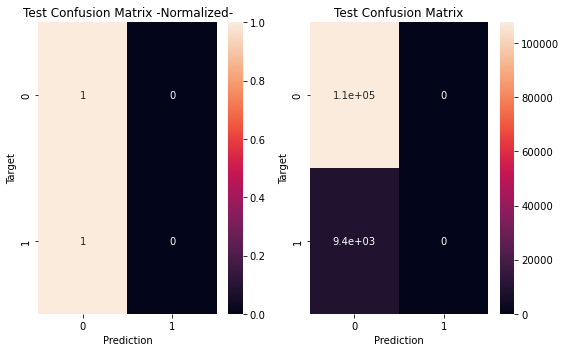

In [264]:
test_preds_NN_2 = search_modelNN_2.predict(X_test[fs_2])
plot_utils.predict_and_plot(test_preds_NN_2, y_test, 'Test')
acc = search_modelNN_2.score(X_test[fs_2], y_test)
rec = recall_score(y_true=y_test, y_pred=test_preds_NN_2)
f1 = f1_score(y_true=y_test, y_pred=test_preds_NN_2)

<ipython-input-265-d1aa2c6fa494>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


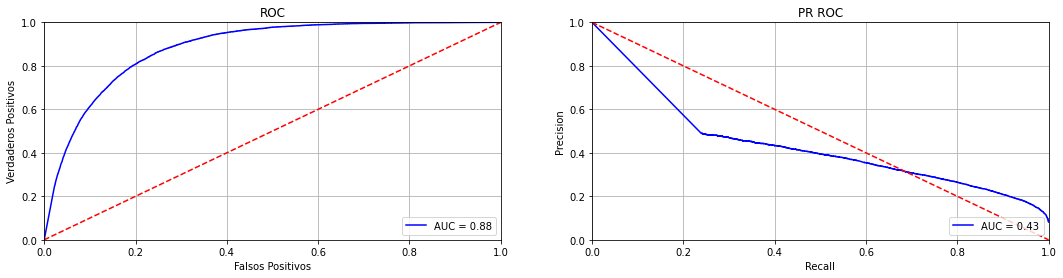

In [265]:
y_pred_NN_2 = search_modelNN_2.predict_proba(X_test[fs_2])

preds_NN_2 = y_pred_NN_2[:,1]

fpr, tpr, threshold = roc_curve(y_test, preds_NN_2)
roc_auc_NN_2 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_NN_2)
pr_roc_auc_NN_2 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_NN_2)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_NN_2)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [266]:
results['modelNN_2'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_NN_2, 'prc': pr_roc_auc_NN_2, 'params': search_modelNN_2.best_params_}
results['modelNN_2']

{'acc': 0.9199268801038712,
 'rec': 0.0,
 'f1': 0.0,
 'auc': 0.8836294360822226,
 'prc': 0.4338368007946478,
 'params': {'classifier__hidden_layer_sizes': (32, 8, 2),
  'classifier__learning_rate_init': 0.01}}

___

In [267]:
modelNN_3 = Pipeline(steps=[
    ('preprocessor', preprocessor_3),
    ('classifier', MLPClassifier(verbose=True, batch_size=512, activation='relu', solver='adam', max_iter=10, alpha=0.001, random_state=0))
])

In [268]:
search_modelNN_3 = GridSearchCV(modelNN_3, param_grid_NN)

with mlflow.start_run(run_name='modelNN_3') as run_modelNN_3:
    search_modelNN_3.fit(X_train[fs_3], y_train)

2022/04/18 09:40:18 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler(...`


Iteration 1, loss = 0.21084121
Iteration 2, loss = 0.19946964
Iteration 3, loss = 0.19990231
Iteration 4, loss = 0.19909032
Iteration 5, loss = 0.19799848
Iteration 6, loss = 0.19897419
Iteration 7, loss = 0.19827030
Iteration 8, loss = 0.19808008
Iteration 9, loss = 0.19746357
Iteration 10, loss = 0.19752967


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21215149
Iteration 2, loss = 0.19990762
Iteration 3, loss = 0.19944587
Iteration 4, loss = 0.19893762
Iteration 5, loss = 0.19800049
Iteration 6, loss = 0.19770065
Iteration 7, loss = 0.19829802
Iteration 8, loss = 0.19858727
Iteration 9, loss = 0.19808835
Iteration 10, loss = 0.19742948


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21207936
Iteration 2, loss = 0.20018782
Iteration 3, loss = 0.20110962
Iteration 4, loss = 0.19882837
Iteration 5, loss = 0.19962986
Iteration 6, loss = 0.19836075
Iteration 7, loss = 0.19879210
Iteration 8, loss = 0.19822064
Iteration 9, loss = 0.19824600
Iteration 10, loss = 0.19764022


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21200624
Iteration 2, loss = 0.20214131
Iteration 3, loss = 0.20054516
Iteration 4, loss = 0.19916017
Iteration 5, loss = 0.19962567
Iteration 6, loss = 0.19929261
Iteration 7, loss = 0.19884998
Iteration 8, loss = 0.19999082
Iteration 9, loss = 0.19948033
Iteration 10, loss = 0.19848764


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21446071
Iteration 2, loss = 0.20221559
Iteration 3, loss = 0.19995211
Iteration 4, loss = 0.20033617
Iteration 5, loss = 0.19914438
Iteration 6, loss = 0.19957046
Iteration 7, loss = 0.19914558
Iteration 8, loss = 0.19878790
Iteration 9, loss = 0.19850077
Iteration 10, loss = 0.19821348


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.20724884
Iteration 2, loss = 0.20354491
Iteration 3, loss = 0.20341354
Iteration 4, loss = 0.20346413
Iteration 5, loss = 0.20201494
Iteration 6, loss = 0.20217427
Iteration 7, loss = 0.20313305
Iteration 8, loss = 0.20261147
Iteration 9, loss = 0.20314233
Iteration 10, loss = 0.20225806


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.20936672
Iteration 2, loss = 0.20320230
Iteration 3, loss = 0.20183745
Iteration 4, loss = 0.20241389
Iteration 5, loss = 0.20460642
Iteration 6, loss = 0.20269051
Iteration 7, loss = 0.20356375
Iteration 8, loss = 0.20403719
Iteration 9, loss = 0.20294211
Iteration 10, loss = 0.20191494


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.20840964
Iteration 2, loss = 0.20307661
Iteration 3, loss = 0.20259650
Iteration 4, loss = 0.20289850
Iteration 5, loss = 0.20237813
Iteration 6, loss = 0.20250528
Iteration 7, loss = 0.20549732
Iteration 8, loss = 0.20368566
Iteration 9, loss = 0.20231784
Iteration 10, loss = 0.20278657


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.20814411
Iteration 2, loss = 0.20445795
Iteration 3, loss = 0.20339502
Iteration 4, loss = 0.20369641
Iteration 5, loss = 0.20594454
Iteration 6, loss = 0.20651608
Iteration 7, loss = 0.20524266
Iteration 8, loss = 0.20621792
Iteration 9, loss = 0.20369721
Iteration 10, loss = 0.20461010


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.20852218
Iteration 2, loss = 0.20368789
Iteration 3, loss = 0.20317699
Iteration 4, loss = 0.20239674
Iteration 5, loss = 0.20433245
Iteration 6, loss = 0.20332902
Iteration 7, loss = 0.20319652
Iteration 8, loss = 0.20441528
Iteration 9, loss = 0.20415351
Iteration 10, loss = 0.20341981


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.20961014
Iteration 2, loss = 0.20762170
Iteration 3, loss = 0.20808804
Iteration 4, loss = 0.20979737
Iteration 5, loss = 0.20565959
Iteration 6, loss = 0.20567207
Iteration 7, loss = 0.20897981
Iteration 8, loss = 0.20694810
Iteration 9, loss = 0.20847201
Iteration 10, loss = 0.20466954


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.20975984
Iteration 2, loss = 0.20668523
Iteration 3, loss = 0.20544060
Iteration 4, loss = 0.20869320
Iteration 5, loss = 0.21210963
Iteration 6, loss = 0.20738791
Iteration 7, loss = 0.20809574
Iteration 8, loss = 0.20769010
Iteration 9, loss = 0.20960074
Iteration 10, loss = 0.20799974


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21078812
Iteration 2, loss = 0.20649410
Iteration 3, loss = 0.20555070
Iteration 4, loss = 0.20751974
Iteration 5, loss = 0.20781181
Iteration 6, loss = 0.20657988
Iteration 7, loss = 0.20609125
Iteration 8, loss = 0.20716228
Iteration 9, loss = 0.20748404
Iteration 10, loss = 0.21043090


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21213423
Iteration 2, loss = 0.20720905
Iteration 3, loss = 0.20592981
Iteration 4, loss = 0.20635321
Iteration 5, loss = 0.20643935
Iteration 6, loss = 0.20741411
Iteration 7, loss = 0.20571895
Iteration 8, loss = 0.20638819
Iteration 9, loss = 0.20615076
Iteration 10, loss = 0.20586695


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21100481
Iteration 2, loss = 0.20743362
Iteration 3, loss = 0.20690203
Iteration 4, loss = 0.20818744
Iteration 5, loss = 0.20925579
Iteration 6, loss = 0.20754123
Iteration 7, loss = 0.20852985
Iteration 8, loss = 0.21074933
Iteration 9, loss = 0.23133310
Iteration 10, loss = 0.23265427


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21450295
Iteration 2, loss = 0.20037591
Iteration 3, loss = 0.19888832
Iteration 4, loss = 0.19925986
Iteration 5, loss = 0.19786692
Iteration 6, loss = 0.19797534
Iteration 7, loss = 0.19752325
Iteration 8, loss = 0.19789609
Iteration 9, loss = 0.19755005
Iteration 10, loss = 0.19758151


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21414900
Iteration 2, loss = 0.20074519
Iteration 3, loss = 0.19868209
Iteration 4, loss = 0.19842769
Iteration 5, loss = 0.19820476
Iteration 6, loss = 0.19794616
Iteration 7, loss = 0.19865981
Iteration 8, loss = 0.19781514
Iteration 9, loss = 0.19805860
Iteration 10, loss = 0.19788115


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21742574
Iteration 2, loss = 0.20020654
Iteration 3, loss = 0.19994011
Iteration 4, loss = 0.19929871
Iteration 5, loss = 0.19879390
Iteration 6, loss = 0.19821688
Iteration 7, loss = 0.19865726
Iteration 8, loss = 0.19835937
Iteration 9, loss = 0.19882906
Iteration 10, loss = 0.19842729


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21652945
Iteration 2, loss = 0.20179947
Iteration 3, loss = 0.20004763
Iteration 4, loss = 0.19987076
Iteration 5, loss = 0.19942274
Iteration 6, loss = 0.19983804
Iteration 7, loss = 0.19903452
Iteration 8, loss = 0.19936384
Iteration 9, loss = 0.19885509
Iteration 10, loss = 0.19869994


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.22070037
Iteration 2, loss = 0.20258803
Iteration 3, loss = 0.19974322
Iteration 4, loss = 0.19958227
Iteration 5, loss = 0.19893373
Iteration 6, loss = 0.19852503
Iteration 7, loss = 0.19863992
Iteration 8, loss = 0.19873600
Iteration 9, loss = 0.19813570
Iteration 10, loss = 0.19792372


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21118093
Iteration 2, loss = 0.20286320
Iteration 3, loss = 0.20251255
Iteration 4, loss = 0.20230201
Iteration 5, loss = 0.20192825
Iteration 6, loss = 0.20352610
Iteration 7, loss = 0.20243098
Iteration 8, loss = 0.20162331
Iteration 9, loss = 0.20236936
Iteration 10, loss = 0.20295997


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.20937222
Iteration 2, loss = 0.20141299
Iteration 3, loss = 0.20082266
Iteration 4, loss = 0.20370796
Iteration 5, loss = 0.20244485
Iteration 6, loss = 0.20281029
Iteration 7, loss = 0.20316758
Iteration 8, loss = 0.20227107
Iteration 9, loss = 0.20276564
Iteration 10, loss = 0.20392737


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.20979258
Iteration 2, loss = 0.20337700
Iteration 3, loss = 0.20171947
Iteration 4, loss = 0.20214176
Iteration 5, loss = 0.20196075
Iteration 6, loss = 0.20316992
Iteration 7, loss = 0.20273230
Iteration 8, loss = 0.20409108
Iteration 9, loss = 0.20344099
Iteration 10, loss = 0.20435510


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.20947498
Iteration 2, loss = 0.20375593
Iteration 3, loss = 0.20430233
Iteration 4, loss = 0.20242057
Iteration 5, loss = 0.20364816
Iteration 6, loss = 0.20402784
Iteration 7, loss = 0.20352314
Iteration 8, loss = 0.20376770
Iteration 9, loss = 0.20362466
Iteration 10, loss = 0.20451788


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.20928057
Iteration 2, loss = 0.20550161
Iteration 3, loss = 0.20311393
Iteration 4, loss = 0.20272892
Iteration 5, loss = 0.20332696
Iteration 6, loss = 0.20418059
Iteration 7, loss = 0.20279659
Iteration 8, loss = 0.20282395
Iteration 9, loss = 0.20331992
Iteration 10, loss = 0.20345023


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21160950
Iteration 2, loss = 0.20918281
Iteration 3, loss = 0.20943078
Iteration 4, loss = 0.20920678
Iteration 5, loss = 0.20613474
Iteration 6, loss = 0.20701028
Iteration 7, loss = 0.20708296
Iteration 8, loss = 0.20468114
Iteration 9, loss = 0.20721640
Iteration 10, loss = 0.20781109


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21270421
Iteration 2, loss = 0.20622790
Iteration 3, loss = 0.20673112
Iteration 4, loss = 0.20767514
Iteration 5, loss = 0.20724262
Iteration 6, loss = 0.20644564
Iteration 7, loss = 0.20831235
Iteration 8, loss = 0.20586272
Iteration 9, loss = 0.28220478
Iteration 10, loss = 0.28023555


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21037294
Iteration 2, loss = 0.21585306
Iteration 3, loss = 0.20792745
Iteration 4, loss = 0.20475390
Iteration 5, loss = 0.20535339
Iteration 6, loss = 0.20525571
Iteration 7, loss = 0.20552342
Iteration 8, loss = 0.20883419
Iteration 9, loss = 0.20860903
Iteration 10, loss = 0.20817289


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21474172
Iteration 2, loss = 0.20415141
Iteration 3, loss = 0.20378008
Iteration 4, loss = 0.20371660
Iteration 5, loss = 0.20465879
Iteration 6, loss = 0.20401999
Iteration 7, loss = 0.20421645
Iteration 8, loss = 0.20609586
Iteration 9, loss = 0.20595048
Iteration 10, loss = 0.20588648


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.21235630
Iteration 2, loss = 0.20745401
Iteration 3, loss = 0.20830551
Iteration 4, loss = 0.20426595
Iteration 5, loss = 0.21088140
Iteration 6, loss = 0.20884730
Iteration 7, loss = 0.20917201
Iteration 8, loss = 0.20825999
Iteration 9, loss = 0.20654716
Iteration 10, loss = 0.20613510


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.20992841
Iteration 2, loss = 0.19996868
Iteration 3, loss = 0.20040485
Iteration 4, loss = 0.19894797
Iteration 5, loss = 0.19877739
Iteration 6, loss = 0.19915396
Iteration 7, loss = 0.19857861
Iteration 8, loss = 0.19854888
Iteration 9, loss = 0.19870065
Iteration 10, loss = 0.19800485


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
2022/04/18 09:45:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing

In [269]:
print("Best parameter (CV score=%0.3f):" % search_modelNN_3.best_score_)
print(search_modelNN_3.best_params_)

Best parameter (CV score=0.921):
{'classifier__hidden_layer_sizes': (32, 8, 2), 'classifier__learning_rate_init': 0.01}


Accuracy: 92.08%


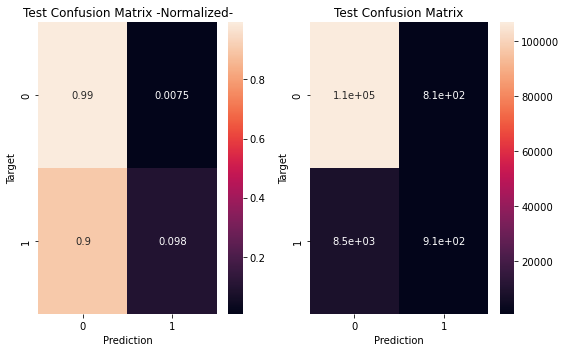

In [270]:
test_preds_NN_3 = search_modelNN_3.predict(X_test[fs_3])
plot_utils.predict_and_plot(test_preds_NN_3, y_test, 'Test')
acc = search_modelNN_3.score(X_test[fs_3], y_test)
rec = recall_score(y_true=y_test, y_pred=test_preds_NN_3)
f1 = f1_score(y_true=y_test, y_pred=test_preds_NN_3)

<ipython-input-271-cb87e084d8d2>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


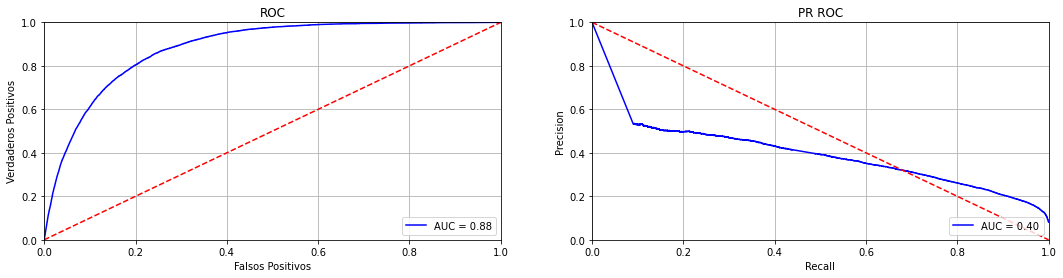

In [271]:
y_pred_NN_3 = search_modelNN_3.predict_proba(X_test[fs_3])

preds_NN_3 = y_pred_NN_3[:,1]

fpr, tpr, threshold = roc_curve(y_test, preds_NN_3)
roc_auc_NN_3 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_NN_3)
pr_roc_auc_NN_3 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_NN_3)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_NN_3)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [272]:
results['modelNN_3'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_NN_3, 'prc': pr_roc_auc_NN_3, 'params': search_modelNN_3.best_params_}
results['modelNN_3']

{'acc': 0.9208408788054806,
 'rec': 0.09750373373159804,
 'f1': 0.1647589004055881,
 'auc': 0.8832271641415765,
 'prc': 0.39967800791601105,
 'params': {'classifier__hidden_layer_sizes': (32, 8, 2),
  'classifier__learning_rate_init': 0.01}}

___

#### 6.2.5 XGBoost

In [274]:
param_grid_XGB = {
    'classifier__n_estimators': [20, 50, 100], 
    'classifier__max_depth': [5, 15, 30],
}

___

In [276]:
modelXGB_0 = Pipeline(steps=[
    ('preprocessor', preprocessor_0),
    ('classifier', xgb.XGBClassifier(random_state=42))
])

In [277]:
search_modelXGB_0 = GridSearchCV(modelXGB_0, param_grid_XGB)

with mlflow.start_run(run_name='modelXGB_0') as run_modelXGB_0:
    search_modelXGB_0.fit(X_train[fs_0], y_train)

2022/04/18 09:47:11 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler(...`
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:47:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:47:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:47:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:48:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:48:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:48:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 09:49:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1c8cb169621a4c2fb6929f9eafedc6ac. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'num_boost_round\' was already logged with value=\'20\' for run ID=\'1c8cb169621a4c2fb6929f9eafedc6ac\'. Attempted logging new value \'50\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_

[09:49:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 09:49:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1c8cb169621a4c2fb6929f9eafedc6ac. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'num_boost_round\' was already logged with value=\'20\' for run ID=\'1c8cb169621a4c2fb6929f9eafedc6ac\'. Attempted logging new value \'50\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_

[09:49:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 09:49:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1c8cb169621a4c2fb6929f9eafedc6ac. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'num_boost_round\' was already logged with value=\'20\' for run ID=\'1c8cb169621a4c2fb6929f9eafedc6ac\'. Attempted logging new value \'50\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_

[09:49:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 09:50:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1c8cb169621a4c2fb6929f9eafedc6ac. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'num_boost_round\' was already logged with value=\'20\' for run ID=\'1c8cb169621a4c2fb6929f9eafedc6ac\'. Attempted logging new value \'50\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_

[09:50:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 09:50:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1c8cb169621a4c2fb6929f9eafedc6ac. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'num_boost_round\' was already logged with value=\'20\' for run ID=\'1c8cb169621a4c2fb6929f9eafedc6ac\'. Attempted logging new value \'50\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_

[09:50:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 09:51:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1c8cb169621a4c2fb6929f9eafedc6ac. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'num_boost_round\' was already logged with value=\'20\' for run ID=\'1c8cb169621a4c2fb6929f9eafedc6ac\'. Attempted logging new value \'100\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label

[09:51:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 09:52:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1c8cb169621a4c2fb6929f9eafedc6ac. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'num_boost_round\' was already logged with value=\'20\' for run ID=\'1c8cb169621a4c2fb6929f9eafedc6ac\'. Attempted logging new value \'100\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label

[09:52:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 09:52:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1c8cb169621a4c2fb6929f9eafedc6ac. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'num_boost_round\' was already logged with value=\'20\' for run ID=\'1c8cb169621a4c2fb6929f9eafedc6ac\'. Attempted logging new value \'100\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label

[09:52:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 09:53:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1c8cb169621a4c2fb6929f9eafedc6ac. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'num_boost_round\' was already logged with value=\'20\' for run ID=\'1c8cb169621a4c2fb6929f9eafedc6ac\'. Attempted logging new value \'100\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label

[09:53:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 09:54:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1c8cb169621a4c2fb6929f9eafedc6ac. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'num_boost_round\' was already logged with value=\'20\' for run ID=\'1c8cb169621a4c2fb6929f9eafedc6ac\'. Attempted logging new value \'100\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label

[09:54:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 09:54:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1c8cb169621a4c2fb6929f9eafedc6ac. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'1c8cb169621a4c2fb6929f9eafedc6ac\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[09:54:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 09:55:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1c8cb169621a4c2fb6929f9eafedc6ac. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'1c8cb169621a4c2fb6929f9eafedc6ac\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[09:55:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 09:55:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1c8cb169621a4c2fb6929f9eafedc6ac. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'1c8cb169621a4c2fb6929f9eafedc6ac\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[09:55:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 09:56:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1c8cb169621a4c2fb6929f9eafedc6ac. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'1c8cb169621a4c2fb6929f9eafedc6ac\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[09:56:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 09:56:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1c8cb169621a4c2fb6929f9eafedc6ac. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'1c8cb169621a4c2fb6929f9eafedc6ac\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[09:56:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 09:57:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1c8cb169621a4c2fb6929f9eafedc6ac. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'1c8cb169621a4c2fb6929f9eafedc6ac\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[09:57:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 09:58:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1c8cb169621a4c2fb6929f9eafedc6ac. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'1c8cb169621a4c2fb6929f9eafedc6ac\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[09:58:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 09:59:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1c8cb169621a4c2fb6929f9eafedc6ac. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'1c8cb169621a4c2fb6929f9eafedc6ac\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[09:59:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 10:00:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1c8cb169621a4c2fb6929f9eafedc6ac. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'1c8cb169621a4c2fb6929f9eafedc6ac\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[10:00:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 10:01:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1c8cb169621a4c2fb6929f9eafedc6ac. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'1c8cb169621a4c2fb6929f9eafedc6ac\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[10:01:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 10:03:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1c8cb169621a4c2fb6929f9eafedc6ac. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'1c8cb169621a4c2fb6929f9eafedc6ac\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[10:03:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 10:05:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1c8cb169621a4c2fb6929f9eafedc6ac. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'1c8cb169621a4c2fb6929f9eafedc6ac\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[10:05:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 10:07:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1c8cb169621a4c2fb6929f9eafedc6ac. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'1c8cb169621a4c2fb6929f9eafedc6ac\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[10:07:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 10:08:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1c8cb169621a4c2fb6929f9eafedc6ac. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'1c8cb169621a4c2fb6929f9eafedc6ac\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[10:09:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 10:10:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1c8cb169621a4c2fb6929f9eafedc6ac. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'1c8cb169621a4c2fb6929f9eafedc6ac\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[10:10:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 10:11:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1c8cb169621a4c2fb6929f9eafedc6ac. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'1c8cb169621a4c2fb6929f9eafedc6ac\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[10:11:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 10:12:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1c8cb169621a4c2fb6929f9eafedc6ac. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'1c8cb169621a4c2fb6929f9eafedc6ac\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[10:12:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 10:13:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1c8cb169621a4c2fb6929f9eafedc6ac. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'1c8cb169621a4c2fb6929f9eafedc6ac\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[10:13:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 10:14:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1c8cb169621a4c2fb6929f9eafedc6ac. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'1c8cb169621a4c2fb6929f9eafedc6ac\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[10:14:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 10:14:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1c8cb169621a4c2fb6929f9eafedc6ac. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'1c8cb169621a4c2fb6929f9eafedc6ac\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[10:14:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 10:16:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1c8cb169621a4c2fb6929f9eafedc6ac. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'1c8cb169621a4c2fb6929f9eafedc6ac\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[10:16:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 10:18:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1c8cb169621a4c2fb6929f9eafedc6ac. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'1c8cb169621a4c2fb6929f9eafedc6ac\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[10:18:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 10:20:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1c8cb169621a4c2fb6929f9eafedc6ac. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'1c8cb169621a4c2fb6929f9eafedc6ac\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[10:20:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 10:22:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1c8cb169621a4c2fb6929f9eafedc6ac. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'1c8cb169621a4c2fb6929f9eafedc6ac\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[10:22:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 10:24:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1c8cb169621a4c2fb6929f9eafedc6ac. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'1c8cb169621a4c2fb6929f9eafedc6ac\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[10:24:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 10:27:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1c8cb169621a4c2fb6929f9eafedc6ac. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'1c8cb169621a4c2fb6929f9eafedc6ac\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[10:27:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 10:31:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1c8cb169621a4c2fb6929f9eafedc6ac. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'1c8cb169621a4c2fb6929f9eafedc6ac\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[10:31:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 10:34:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1c8cb169621a4c2fb6929f9eafedc6ac. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'1c8cb169621a4c2fb6929f9eafedc6ac\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[10:34:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 10:37:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1c8cb169621a4c2fb6929f9eafedc6ac. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'1c8cb169621a4c2fb6929f9eafedc6ac\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[10:37:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 10:41:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1c8cb169621a4c2fb6929f9eafedc6ac. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'1c8cb169621a4c2fb6929f9eafedc6ac\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[10:41:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 10:41:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1c8cb169621a4c2fb6929f9eafedc6ac. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'num_boost_round\' was already logged with value=\'20\' for run ID=\'1c8cb169621a4c2fb6929f9eafedc6ac\'. Attempted logging new value \'50\'."))]')]
2022/04/18 10:41:43 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema e

In [278]:
print("Best parameter (CV score=%0.3f):" % search_modelXGB_0.best_score_)
print(search_modelXGB_0.best_params_)

Best parameter (CV score=0.922):
{'classifier__max_depth': 5, 'classifier__n_estimators': 50}


Accuracy: 92.24%


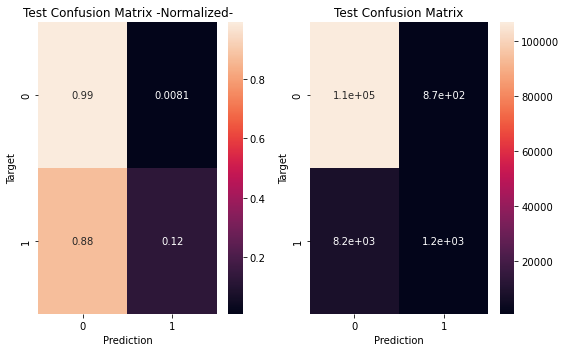

In [279]:
test_preds_XGB_0 = search_modelXGB_0.predict(X_test[fs_0])
plot_utils.predict_and_plot(test_preds_XGB_0, y_test, 'Test')
acc = search_modelXGB_0.score(X_test[fs_0], y_test)
rec = recall_score(y_true=y_test, y_pred=test_preds_XGB_0)
f1 = f1_score(y_true=y_test, y_pred=test_preds_XGB_0)

<ipython-input-280-3afd5ee1066e>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


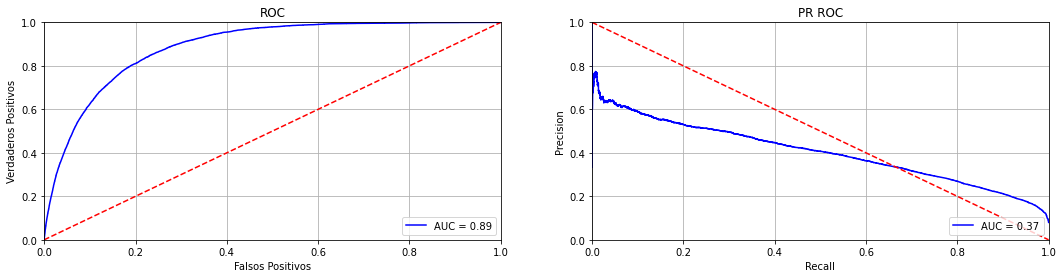

In [280]:
y_pred_XGB_0 = search_modelXGB_0.predict_proba(X_test[fs_0])

preds_XGB_0 = y_pred_XGB_0[:,1]

fpr, tpr, threshold = roc_curve(y_test, preds_XGB_0)
roc_auc_XGB_0 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_XGB_0)
pr_roc_auc_XGB_0 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_XGB_0)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_NN_0)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [281]:
results['modelXGB_0'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_XGB_0, 'prc': pr_roc_auc_XGB_0, 'params': search_modelXGB_0.best_params_}
results['modelXGB_0']

{'acc': 0.9224040728465507,
 'rec': 0.1237465329635161,
 'f1': 0.20343739038933706,
 'auc': 0.8873838848788587,
 'prc': 0.403342563288828,
 'params': {'classifier__max_depth': 5, 'classifier__n_estimators': 50}}

___

In [282]:
modelXGB_1 = Pipeline(steps=[
    ('preprocessor', preprocessor_1),
    ('classifier', xgb.XGBClassifier(random_state=42))
])

In [283]:
search_modelXGB_1 = GridSearchCV(modelXGB_1, param_grid_XGB)

with mlflow.start_run(run_name='modelXGB_1') as run_modelXGB_1:
    search_modelXGB_1.fit(X_train[fs_1], y_train)

2022/04/18 10:42:01 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler(...`
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:42:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:42:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:42:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:42:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:43:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:43:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 10:43:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 72bc17acd1c64fa792170e19d4d15340. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'num_boost_round\' was already logged with value=\'20\' for run ID=\'72bc17acd1c64fa792170e19d4d15340\'. Attempted logging new value \'50\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_

[10:43:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 10:44:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 72bc17acd1c64fa792170e19d4d15340. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'num_boost_round\' was already logged with value=\'20\' for run ID=\'72bc17acd1c64fa792170e19d4d15340\'. Attempted logging new value \'50\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_

[10:44:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 10:44:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 72bc17acd1c64fa792170e19d4d15340. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'num_boost_round\' was already logged with value=\'20\' for run ID=\'72bc17acd1c64fa792170e19d4d15340\'. Attempted logging new value \'50\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_

[10:44:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 10:44:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 72bc17acd1c64fa792170e19d4d15340. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'num_boost_round\' was already logged with value=\'20\' for run ID=\'72bc17acd1c64fa792170e19d4d15340\'. Attempted logging new value \'50\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_

[10:44:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 10:45:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 72bc17acd1c64fa792170e19d4d15340. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'num_boost_round\' was already logged with value=\'20\' for run ID=\'72bc17acd1c64fa792170e19d4d15340\'. Attempted logging new value \'50\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_

[10:45:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 10:45:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 72bc17acd1c64fa792170e19d4d15340. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'num_boost_round\' was already logged with value=\'20\' for run ID=\'72bc17acd1c64fa792170e19d4d15340\'. Attempted logging new value \'100\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label

[10:45:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 10:46:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 72bc17acd1c64fa792170e19d4d15340. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'num_boost_round\' was already logged with value=\'20\' for run ID=\'72bc17acd1c64fa792170e19d4d15340\'. Attempted logging new value \'100\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label

[10:46:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 10:47:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 72bc17acd1c64fa792170e19d4d15340. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'num_boost_round\' was already logged with value=\'20\' for run ID=\'72bc17acd1c64fa792170e19d4d15340\'. Attempted logging new value \'100\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label

[10:47:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 10:47:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 72bc17acd1c64fa792170e19d4d15340. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'num_boost_round\' was already logged with value=\'20\' for run ID=\'72bc17acd1c64fa792170e19d4d15340\'. Attempted logging new value \'100\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label

[10:47:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 10:48:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 72bc17acd1c64fa792170e19d4d15340. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'num_boost_round\' was already logged with value=\'20\' for run ID=\'72bc17acd1c64fa792170e19d4d15340\'. Attempted logging new value \'100\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label

[10:48:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 10:49:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 72bc17acd1c64fa792170e19d4d15340. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'72bc17acd1c64fa792170e19d4d15340\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[10:49:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 10:49:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 72bc17acd1c64fa792170e19d4d15340. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'72bc17acd1c64fa792170e19d4d15340\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[10:49:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 10:49:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 72bc17acd1c64fa792170e19d4d15340. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'72bc17acd1c64fa792170e19d4d15340\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[10:50:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 10:50:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 72bc17acd1c64fa792170e19d4d15340. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'72bc17acd1c64fa792170e19d4d15340\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[10:50:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 10:50:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 72bc17acd1c64fa792170e19d4d15340. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'72bc17acd1c64fa792170e19d4d15340\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[10:50:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 10:51:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 72bc17acd1c64fa792170e19d4d15340. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'72bc17acd1c64fa792170e19d4d15340\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[10:51:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 10:52:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 72bc17acd1c64fa792170e19d4d15340. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'72bc17acd1c64fa792170e19d4d15340\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[10:52:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 10:53:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 72bc17acd1c64fa792170e19d4d15340. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'72bc17acd1c64fa792170e19d4d15340\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[10:53:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 10:54:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 72bc17acd1c64fa792170e19d4d15340. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'72bc17acd1c64fa792170e19d4d15340\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[10:54:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 10:55:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 72bc17acd1c64fa792170e19d4d15340. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'72bc17acd1c64fa792170e19d4d15340\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[10:55:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 10:57:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 72bc17acd1c64fa792170e19d4d15340. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'72bc17acd1c64fa792170e19d4d15340\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[10:57:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 10:59:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 72bc17acd1c64fa792170e19d4d15340. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'72bc17acd1c64fa792170e19d4d15340\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[10:59:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:01:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 72bc17acd1c64fa792170e19d4d15340. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'72bc17acd1c64fa792170e19d4d15340\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[11:01:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:02:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 72bc17acd1c64fa792170e19d4d15340. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'72bc17acd1c64fa792170e19d4d15340\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[11:02:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:04:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 72bc17acd1c64fa792170e19d4d15340. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'72bc17acd1c64fa792170e19d4d15340\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[11:04:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:05:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 72bc17acd1c64fa792170e19d4d15340. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'72bc17acd1c64fa792170e19d4d15340\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[11:05:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:06:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 72bc17acd1c64fa792170e19d4d15340. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'72bc17acd1c64fa792170e19d4d15340\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[11:06:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:07:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 72bc17acd1c64fa792170e19d4d15340. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'72bc17acd1c64fa792170e19d4d15340\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[11:07:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:08:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 72bc17acd1c64fa792170e19d4d15340. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'72bc17acd1c64fa792170e19d4d15340\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[11:08:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:08:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 72bc17acd1c64fa792170e19d4d15340. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'72bc17acd1c64fa792170e19d4d15340\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[11:08:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:10:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 72bc17acd1c64fa792170e19d4d15340. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'72bc17acd1c64fa792170e19d4d15340\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[11:10:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:12:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 72bc17acd1c64fa792170e19d4d15340. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'72bc17acd1c64fa792170e19d4d15340\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[11:12:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:14:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 72bc17acd1c64fa792170e19d4d15340. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'72bc17acd1c64fa792170e19d4d15340\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[11:14:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:16:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 72bc17acd1c64fa792170e19d4d15340. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'72bc17acd1c64fa792170e19d4d15340\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[11:16:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:18:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 72bc17acd1c64fa792170e19d4d15340. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'72bc17acd1c64fa792170e19d4d15340\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[11:18:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:21:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 72bc17acd1c64fa792170e19d4d15340. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'72bc17acd1c64fa792170e19d4d15340\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[11:21:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:25:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 72bc17acd1c64fa792170e19d4d15340. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'72bc17acd1c64fa792170e19d4d15340\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[11:25:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:28:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 72bc17acd1c64fa792170e19d4d15340. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'72bc17acd1c64fa792170e19d4d15340\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[11:28:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:32:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 72bc17acd1c64fa792170e19d4d15340. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'72bc17acd1c64fa792170e19d4d15340\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[11:32:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:35:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 72bc17acd1c64fa792170e19d4d15340. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'72bc17acd1c64fa792170e19d4d15340\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[11:35:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:35:46 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2022/04/18 11:35:54 INFO mlflow.sklearn.utils: Logging the 5 best runs, 4 runs will be omitted.
2022/04/18 11:35:54 WARNING mlflow.uti

In [284]:
print("Best parameter (CV score=%0.3f):" % search_modelXGB_1.best_score_)
print(search_modelXGB_1.best_params_)

Best parameter (CV score=0.922):
{'classifier__max_depth': 5, 'classifier__n_estimators': 20}


Accuracy: 92.26%


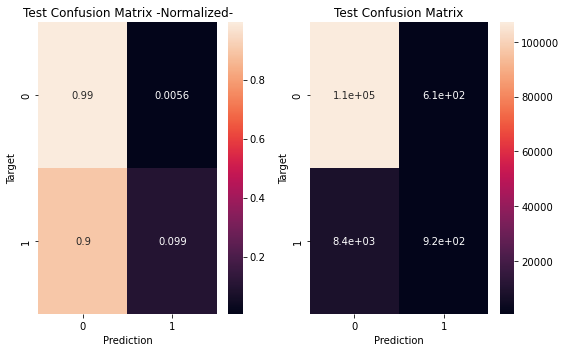

In [285]:
test_preds_XGB_1 = search_modelXGB_1.predict(X_test[fs_1])
plot_utils.predict_and_plot(test_preds_XGB_1, y_test, 'Test')
acc = search_modelXGB_1.score(X_test[fs_1], y_test)
rec = recall_score(y_true=y_test, y_pred=test_preds_XGB_1)
f1 = f1_score(y_true=y_test, y_pred=test_preds_XGB_1)

<ipython-input-286-763783a698a4>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


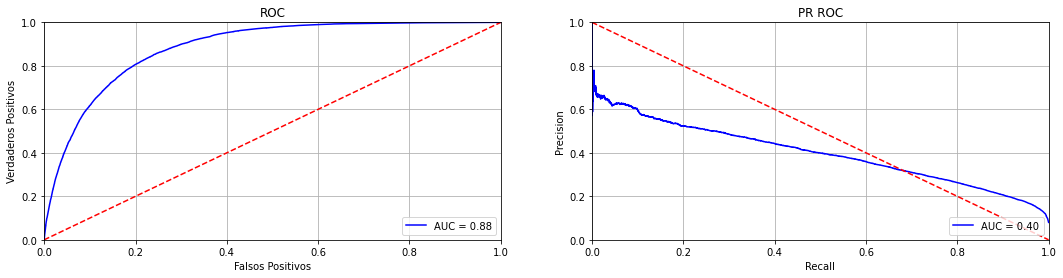

In [286]:
y_pred_XGB_1 = search_modelXGB_1.predict_proba(X_test[fs_1])

preds_XGB_1 = y_pred_XGB_1[:,1]

fpr, tpr, threshold = roc_curve(y_test, preds_XGB_1)
roc_auc_XGB_1 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_XGB_1)
pr_roc_auc_XGB_1 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_XGB_1)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_XGB_1)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [287]:
results['modelXGB_1'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_XGB_1, 'prc': pr_roc_auc_XGB_1, 'params': search_modelXGB_1.best_params_}
results['modelXGB_1']

{'acc': 0.9226432500768784,
 'rec': 0.09857051418818007,
 'f1': 0.16947909024211297,
 'auc': 0.8844507616422573,
 'prc': 0.39853282615864605,
 'params': {'classifier__max_depth': 5, 'classifier__n_estimators': 20}}

___

In [288]:
modelXGB_2 = Pipeline(steps=[
    ('preprocessor', preprocessor_2),
    ('classifier', xgb.XGBClassifier(random_state=42))
])

In [289]:
search_modelXGB_2 = GridSearchCV(modelXGB_2, param_grid_XGB)

with mlflow.start_run(run_name='modelXGB_2') as run_modelXGB_2:
    search_modelXGB_2.fit(X_train[fs_2], y_train)

2022/04/18 11:36:01 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler(...`
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:37:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:37:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 9f1e70dada4e4bc3aa4e2ec2b2d09ecc. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'num_boost_round\' was already logged with value=\'20\' for run ID=\'9f1e70dada4e4bc3aa4e2ec2b2d09ecc\'. Attempted logging new value \'50\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_

[11:37:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:38:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 9f1e70dada4e4bc3aa4e2ec2b2d09ecc. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'num_boost_round\' was already logged with value=\'20\' for run ID=\'9f1e70dada4e4bc3aa4e2ec2b2d09ecc\'. Attempted logging new value \'50\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_

[11:38:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:38:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 9f1e70dada4e4bc3aa4e2ec2b2d09ecc. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'num_boost_round\' was already logged with value=\'20\' for run ID=\'9f1e70dada4e4bc3aa4e2ec2b2d09ecc\'. Attempted logging new value \'50\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_

[11:38:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:38:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 9f1e70dada4e4bc3aa4e2ec2b2d09ecc. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'num_boost_round\' was already logged with value=\'20\' for run ID=\'9f1e70dada4e4bc3aa4e2ec2b2d09ecc\'. Attempted logging new value \'50\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_

[11:38:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:38:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 9f1e70dada4e4bc3aa4e2ec2b2d09ecc. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'num_boost_round\' was already logged with value=\'20\' for run ID=\'9f1e70dada4e4bc3aa4e2ec2b2d09ecc\'. Attempted logging new value \'50\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_

[11:38:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:39:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 9f1e70dada4e4bc3aa4e2ec2b2d09ecc. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'num_boost_round\' was already logged with value=\'20\' for run ID=\'9f1e70dada4e4bc3aa4e2ec2b2d09ecc\'. Attempted logging new value \'100\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label

[11:39:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:40:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 9f1e70dada4e4bc3aa4e2ec2b2d09ecc. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'num_boost_round\' was already logged with value=\'20\' for run ID=\'9f1e70dada4e4bc3aa4e2ec2b2d09ecc\'. Attempted logging new value \'100\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label

[11:40:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:40:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 9f1e70dada4e4bc3aa4e2ec2b2d09ecc. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'num_boost_round\' was already logged with value=\'20\' for run ID=\'9f1e70dada4e4bc3aa4e2ec2b2d09ecc\'. Attempted logging new value \'100\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label

[11:40:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:41:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 9f1e70dada4e4bc3aa4e2ec2b2d09ecc. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'num_boost_round\' was already logged with value=\'20\' for run ID=\'9f1e70dada4e4bc3aa4e2ec2b2d09ecc\'. Attempted logging new value \'100\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label

[11:41:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:41:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 9f1e70dada4e4bc3aa4e2ec2b2d09ecc. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'num_boost_round\' was already logged with value=\'20\' for run ID=\'9f1e70dada4e4bc3aa4e2ec2b2d09ecc\'. Attempted logging new value \'100\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label

[11:41:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:42:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 9f1e70dada4e4bc3aa4e2ec2b2d09ecc. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'9f1e70dada4e4bc3aa4e2ec2b2d09ecc\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[11:42:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:43:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 9f1e70dada4e4bc3aa4e2ec2b2d09ecc. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'9f1e70dada4e4bc3aa4e2ec2b2d09ecc\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[11:43:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:43:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 9f1e70dada4e4bc3aa4e2ec2b2d09ecc. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'9f1e70dada4e4bc3aa4e2ec2b2d09ecc\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[11:43:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:43:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 9f1e70dada4e4bc3aa4e2ec2b2d09ecc. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'9f1e70dada4e4bc3aa4e2ec2b2d09ecc\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[11:44:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:44:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 9f1e70dada4e4bc3aa4e2ec2b2d09ecc. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'9f1e70dada4e4bc3aa4e2ec2b2d09ecc\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[11:44:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:45:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 9f1e70dada4e4bc3aa4e2ec2b2d09ecc. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'9f1e70dada4e4bc3aa4e2ec2b2d09ecc\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[11:45:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:46:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 9f1e70dada4e4bc3aa4e2ec2b2d09ecc. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'9f1e70dada4e4bc3aa4e2ec2b2d09ecc\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[11:46:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:47:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 9f1e70dada4e4bc3aa4e2ec2b2d09ecc. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'9f1e70dada4e4bc3aa4e2ec2b2d09ecc\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[11:47:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:48:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 9f1e70dada4e4bc3aa4e2ec2b2d09ecc. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'9f1e70dada4e4bc3aa4e2ec2b2d09ecc\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[11:48:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:49:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 9f1e70dada4e4bc3aa4e2ec2b2d09ecc. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'9f1e70dada4e4bc3aa4e2ec2b2d09ecc\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[11:49:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:50:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 9f1e70dada4e4bc3aa4e2ec2b2d09ecc. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'9f1e70dada4e4bc3aa4e2ec2b2d09ecc\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[11:50:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:52:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 9f1e70dada4e4bc3aa4e2ec2b2d09ecc. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'9f1e70dada4e4bc3aa4e2ec2b2d09ecc\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[11:52:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:54:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 9f1e70dada4e4bc3aa4e2ec2b2d09ecc. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'9f1e70dada4e4bc3aa4e2ec2b2d09ecc\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[11:54:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:55:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 9f1e70dada4e4bc3aa4e2ec2b2d09ecc. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'9f1e70dada4e4bc3aa4e2ec2b2d09ecc\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[11:55:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:57:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 9f1e70dada4e4bc3aa4e2ec2b2d09ecc. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'9f1e70dada4e4bc3aa4e2ec2b2d09ecc\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[11:57:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:58:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 9f1e70dada4e4bc3aa4e2ec2b2d09ecc. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'9f1e70dada4e4bc3aa4e2ec2b2d09ecc\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[11:58:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:59:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 9f1e70dada4e4bc3aa4e2ec2b2d09ecc. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'9f1e70dada4e4bc3aa4e2ec2b2d09ecc\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[11:59:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 11:59:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 9f1e70dada4e4bc3aa4e2ec2b2d09ecc. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'9f1e70dada4e4bc3aa4e2ec2b2d09ecc\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[11:59:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 12:00:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 9f1e70dada4e4bc3aa4e2ec2b2d09ecc. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'9f1e70dada4e4bc3aa4e2ec2b2d09ecc\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[12:00:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 12:01:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 9f1e70dada4e4bc3aa4e2ec2b2d09ecc. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'9f1e70dada4e4bc3aa4e2ec2b2d09ecc\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[12:01:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 12:03:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 9f1e70dada4e4bc3aa4e2ec2b2d09ecc. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'9f1e70dada4e4bc3aa4e2ec2b2d09ecc\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[12:03:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 12:04:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 9f1e70dada4e4bc3aa4e2ec2b2d09ecc. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'9f1e70dada4e4bc3aa4e2ec2b2d09ecc\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[12:05:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 12:06:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 9f1e70dada4e4bc3aa4e2ec2b2d09ecc. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'9f1e70dada4e4bc3aa4e2ec2b2d09ecc\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[12:06:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 12:08:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 9f1e70dada4e4bc3aa4e2ec2b2d09ecc. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'9f1e70dada4e4bc3aa4e2ec2b2d09ecc\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[12:08:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 12:10:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 9f1e70dada4e4bc3aa4e2ec2b2d09ecc. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'9f1e70dada4e4bc3aa4e2ec2b2d09ecc\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[12:10:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 12:13:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 9f1e70dada4e4bc3aa4e2ec2b2d09ecc. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'9f1e70dada4e4bc3aa4e2ec2b2d09ecc\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[12:13:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 12:16:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 9f1e70dada4e4bc3aa4e2ec2b2d09ecc. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'9f1e70dada4e4bc3aa4e2ec2b2d09ecc\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[12:16:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 12:20:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 9f1e70dada4e4bc3aa4e2ec2b2d09ecc. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'9f1e70dada4e4bc3aa4e2ec2b2d09ecc\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[12:20:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 12:23:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 9f1e70dada4e4bc3aa4e2ec2b2d09ecc. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'9f1e70dada4e4bc3aa4e2ec2b2d09ecc\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[12:23:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 12:26:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 9f1e70dada4e4bc3aa4e2ec2b2d09ecc. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'9f1e70dada4e4bc3aa4e2ec2b2d09ecc\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[12:26:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 12:27:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 9f1e70dada4e4bc3aa4e2ec2b2d09ecc. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'num_boost_round\' was already logged with value=\'20\' for run ID=\'9f1e70dada4e4bc3aa4e2ec2b2d09ecc\'. Attempted logging new value \'50\'."))]')]
2022/04/18 12:27:30 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema e

In [290]:
print("Best parameter (CV score=%0.3f):" % search_modelXGB_2.best_score_)
print(search_modelXGB_2.best_params_)

Best parameter (CV score=0.922):
{'classifier__max_depth': 5, 'classifier__n_estimators': 50}


Accuracy: 92.22%


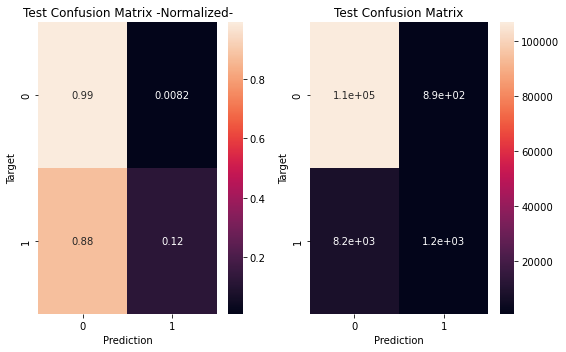

In [291]:
test_preds_XGB_2 = search_modelXGB_2.predict(X_test[fs_2])
plot_utils.predict_and_plot(test_preds_XGB_2, y_test, 'Test')
acc = search_modelXGB_2.score(X_test[fs_2], y_test)
rec = recall_score(y_true=y_test, y_pred=test_preds_XGB_2)
f1 = f1_score(y_true=y_test, y_pred=test_preds_XGB_2)

<ipython-input-293-c29a562ef7ac>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


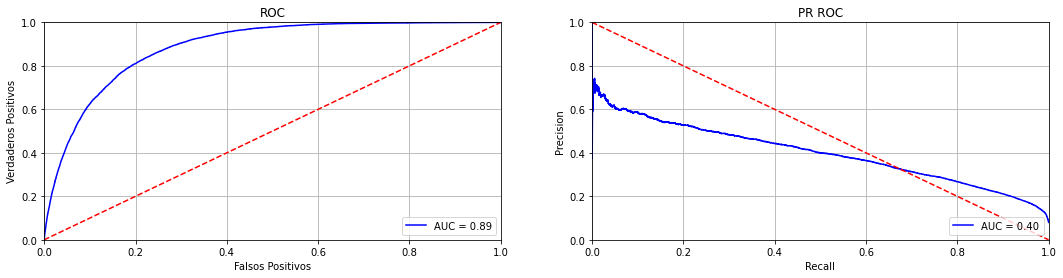

In [293]:
y_pred_XGB_2 = search_modelXGB_2.predict_proba(X_test[fs_2])

preds_XGB_2 = y_pred_XGB_2[:,1]

fpr, tpr, threshold = roc_curve(y_test, preds_XGB_2)
roc_auc_XGB_2 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_XGB_2)
pr_roc_auc_XGB_2 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_XGB_2)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_XGB_2)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [294]:
results['modelXGB_2'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_XGB_2, 'prc': pr_roc_auc_XGB_2, 'params': search_modelXGB_2.best_params_}
results['modelXGB_2']

{'acc': 0.9222161478798647,
 'rec': 0.12321314273522509,
 'f1': 0.20234758234057462,
 'auc': 0.8865962613555894,
 'prc': 0.39927070087593497,
 'params': {'classifier__max_depth': 5, 'classifier__n_estimators': 50}}

___

In [295]:
modelXGB_3 = Pipeline(steps=[
    ('preprocessor', preprocessor_3),
    ('classifier', xgb.XGBClassifier(random_state=42))
])

In [296]:
search_modelXGB_3 = GridSearchCV(modelXGB_3, param_grid_XGB)

with mlflow.start_run(run_name='modelXGB_3') as run_modelXGB_3:
    search_modelXGB_3.fit(X_train[fs_3], y_train)

2022/04/18 13:57:50 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler(...`
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:57:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:58:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:58:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:58:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:58:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:58:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 13:59:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 47b5e135b3ce49408a42f3911adb2a2c. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'num_boost_round\' was already logged with value=\'20\' for run ID=\'47b5e135b3ce49408a42f3911adb2a2c\'. Attempted logging new value \'50\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_

[13:59:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 13:59:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 47b5e135b3ce49408a42f3911adb2a2c. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'num_boost_round\' was already logged with value=\'20\' for run ID=\'47b5e135b3ce49408a42f3911adb2a2c\'. Attempted logging new value \'50\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_

[13:59:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 13:59:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 47b5e135b3ce49408a42f3911adb2a2c. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'num_boost_round\' was already logged with value=\'20\' for run ID=\'47b5e135b3ce49408a42f3911adb2a2c\'. Attempted logging new value \'50\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_

[14:00:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 14:00:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 47b5e135b3ce49408a42f3911adb2a2c. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'num_boost_round\' was already logged with value=\'20\' for run ID=\'47b5e135b3ce49408a42f3911adb2a2c\'. Attempted logging new value \'50\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_

[14:00:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 14:00:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 47b5e135b3ce49408a42f3911adb2a2c. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'num_boost_round\' was already logged with value=\'20\' for run ID=\'47b5e135b3ce49408a42f3911adb2a2c\'. Attempted logging new value \'50\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_

[14:00:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 14:01:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 47b5e135b3ce49408a42f3911adb2a2c. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'num_boost_round\' was already logged with value=\'20\' for run ID=\'47b5e135b3ce49408a42f3911adb2a2c\'. Attempted logging new value \'100\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label

[14:01:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 14:01:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 47b5e135b3ce49408a42f3911adb2a2c. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'num_boost_round\' was already logged with value=\'20\' for run ID=\'47b5e135b3ce49408a42f3911adb2a2c\'. Attempted logging new value \'100\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label

[14:01:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 14:02:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 47b5e135b3ce49408a42f3911adb2a2c. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'num_boost_round\' was already logged with value=\'20\' for run ID=\'47b5e135b3ce49408a42f3911adb2a2c\'. Attempted logging new value \'100\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label

[14:02:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 14:03:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 47b5e135b3ce49408a42f3911adb2a2c. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'num_boost_round\' was already logged with value=\'20\' for run ID=\'47b5e135b3ce49408a42f3911adb2a2c\'. Attempted logging new value \'100\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label

[14:03:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 14:03:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 47b5e135b3ce49408a42f3911adb2a2c. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'num_boost_round\' was already logged with value=\'20\' for run ID=\'47b5e135b3ce49408a42f3911adb2a2c\'. Attempted logging new value \'100\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label

[14:03:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 14:04:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 47b5e135b3ce49408a42f3911adb2a2c. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'47b5e135b3ce49408a42f3911adb2a2c\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[14:04:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 14:04:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 47b5e135b3ce49408a42f3911adb2a2c. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'47b5e135b3ce49408a42f3911adb2a2c\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[14:04:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 14:05:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 47b5e135b3ce49408a42f3911adb2a2c. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'47b5e135b3ce49408a42f3911adb2a2c\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[14:05:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 14:05:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 47b5e135b3ce49408a42f3911adb2a2c. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'47b5e135b3ce49408a42f3911adb2a2c\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[14:05:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 14:06:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 47b5e135b3ce49408a42f3911adb2a2c. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'47b5e135b3ce49408a42f3911adb2a2c\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[14:06:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 14:07:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 47b5e135b3ce49408a42f3911adb2a2c. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'47b5e135b3ce49408a42f3911adb2a2c\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[14:07:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 14:08:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 47b5e135b3ce49408a42f3911adb2a2c. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'47b5e135b3ce49408a42f3911adb2a2c\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[14:08:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 14:09:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 47b5e135b3ce49408a42f3911adb2a2c. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'47b5e135b3ce49408a42f3911adb2a2c\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[14:09:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 14:09:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 47b5e135b3ce49408a42f3911adb2a2c. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'47b5e135b3ce49408a42f3911adb2a2c\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[14:10:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 14:10:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 47b5e135b3ce49408a42f3911adb2a2c. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'47b5e135b3ce49408a42f3911adb2a2c\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[14:10:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 14:12:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 47b5e135b3ce49408a42f3911adb2a2c. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'47b5e135b3ce49408a42f3911adb2a2c\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[14:12:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 14:14:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 47b5e135b3ce49408a42f3911adb2a2c. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'47b5e135b3ce49408a42f3911adb2a2c\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[14:14:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 14:15:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 47b5e135b3ce49408a42f3911adb2a2c. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'47b5e135b3ce49408a42f3911adb2a2c\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[14:15:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 14:17:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 47b5e135b3ce49408a42f3911adb2a2c. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'47b5e135b3ce49408a42f3911adb2a2c\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[14:17:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 14:19:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 47b5e135b3ce49408a42f3911adb2a2c. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'47b5e135b3ce49408a42f3911adb2a2c\'. Attempted logging new value \'15\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[14:19:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 14:20:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 47b5e135b3ce49408a42f3911adb2a2c. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'47b5e135b3ce49408a42f3911adb2a2c\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[14:20:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 14:20:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 47b5e135b3ce49408a42f3911adb2a2c. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'47b5e135b3ce49408a42f3911adb2a2c\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[14:20:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 14:21:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 47b5e135b3ce49408a42f3911adb2a2c. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'47b5e135b3ce49408a42f3911adb2a2c\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[14:21:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 14:22:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 47b5e135b3ce49408a42f3911adb2a2c. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'47b5e135b3ce49408a42f3911adb2a2c\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[14:22:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 14:23:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 47b5e135b3ce49408a42f3911adb2a2c. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'47b5e135b3ce49408a42f3911adb2a2c\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[14:23:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 14:24:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 47b5e135b3ce49408a42f3911adb2a2c. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'47b5e135b3ce49408a42f3911adb2a2c\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[14:24:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 14:26:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 47b5e135b3ce49408a42f3911adb2a2c. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'47b5e135b3ce49408a42f3911adb2a2c\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[14:26:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 14:28:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 47b5e135b3ce49408a42f3911adb2a2c. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'47b5e135b3ce49408a42f3911adb2a2c\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[14:28:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 14:29:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 47b5e135b3ce49408a42f3911adb2a2c. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'47b5e135b3ce49408a42f3911adb2a2c\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[14:29:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 14:31:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 47b5e135b3ce49408a42f3911adb2a2c. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'47b5e135b3ce49408a42f3911adb2a2c\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[14:31:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 14:34:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 47b5e135b3ce49408a42f3911adb2a2c. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'47b5e135b3ce49408a42f3911adb2a2c\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[14:34:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 14:38:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 47b5e135b3ce49408a42f3911adb2a2c. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'47b5e135b3ce49408a42f3911adb2a2c\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[14:38:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 14:41:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 47b5e135b3ce49408a42f3911adb2a2c. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'47b5e135b3ce49408a42f3911adb2a2c\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[14:41:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 14:44:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 47b5e135b3ce49408a42f3911adb2a2c. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'47b5e135b3ce49408a42f3911adb2a2c\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[14:44:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 14:47:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 47b5e135b3ce49408a42f3911adb2a2c. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'47b5e135b3ce49408a42f3911adb2a2c\'. Attempted logging new value \'30\'."))]')]
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder

[14:47:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/04/18 14:48:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 47b5e135b3ce49408a42f3911adb2a2c. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'num_boost_round\' was already logged with value=\'20\' for run ID=\'47b5e135b3ce49408a42f3911adb2a2c\'. Attempted logging new value \'50\'."))]')]
2022/04/18 14:48:15 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema e

In [297]:
print("Best parameter (CV score=%0.3f):" % search_modelXGB_3.best_score_)
print(search_modelXGB_3.best_params_)

Best parameter (CV score=0.922):
{'classifier__max_depth': 5, 'classifier__n_estimators': 50}


Accuracy: 92.21%


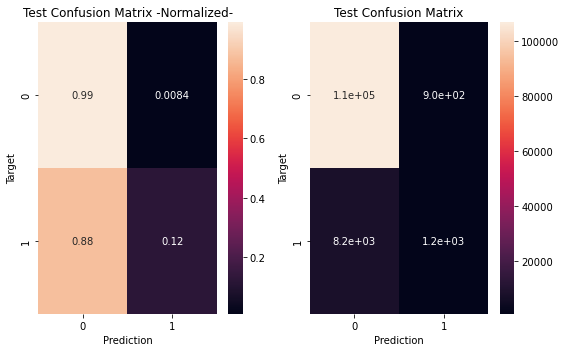

In [298]:
test_preds_XGB_3 = search_modelXGB_3.predict(X_test[fs_3])
plot_utils.predict_and_plot(test_preds_XGB_3, y_test, 'Test')
acc = search_modelXGB_3.score(X_test[fs_3], y_test)
rec = recall_score(y_true=y_test, y_pred=test_preds_XGB_3)
f1 = f1_score(y_true=y_test, y_pred=test_preds_XGB_3)

<ipython-input-299-f4c96d0086ce>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


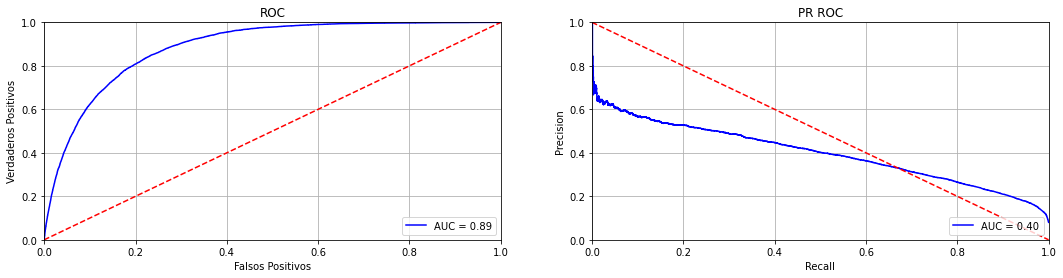

In [299]:
y_pred_XGB_3 = search_modelXGB_3.predict_proba(X_test[fs_3])

preds_XGB_3 = y_pred_XGB_3[:,1]

fpr, tpr, threshold = roc_curve(y_test, preds_XGB_3)
roc_auc_XGB_3 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_XGB_3)
pr_roc_auc_XGB_3 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_XGB_3)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_XGB_3)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [300]:
results['modelXGB_3'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_XGB_3, 'prc': pr_roc_auc_XGB_3, 'params': search_modelXGB_3.best_params_}
results['modelXGB_3']

{'acc': 0.9220880172207606,
 'rec': 0.1235331768721997,
 'f1': 0.2025006557663723,
 'auc': 0.8862757685864241,
 'prc': 0.39849887495636077,
 'params': {'classifier__max_depth': 5, 'classifier__n_estimators': 50}}

___
## 7. Last steps

### 7.1 Model summaries

In [301]:
print('Model results:')
df_results = pd.DataFrame.from_dict(results)
df_results.T

Model results:


,acc,rec,f1,auc,prc,params
modelLR_0,0.919688,0.15767,0.239197,0.859761,0.35388,"{'classifier__C': 1.0, 'classifier__penalty': ..."
modelLR_1,0.921114,0.128227,0.206547,0.861312,0.356234,"{'classifier__C': 0.5, 'classifier__penalty': ..."
modelLR_2,0.920867,0.137828,0.218096,0.86196,0.355234,"{'classifier__C': 0.5, 'classifier__penalty': ..."
modelLR_3,0.921362,0.127907,0.206653,0.865029,0.363179,"{'classifier__C': 1.0, 'classifier__penalty': ..."
modelRF_0,0.922225,0.09249,0.159978,0.884319,0.398901,"{'classifier__max_depth': 20, 'classifier__n_e..."
modelRF_1,0.922088,0.091423,0.158191,0.883603,0.395927,"{'classifier__max_depth': 20, 'classifier__n_e..."
modelRF_2,0.922148,0.090463,0.156892,0.883169,0.3954,"{'classifier__max_depth': 20, 'classifier__n_e..."
modelRF_3,0.922327,0.094837,0.163554,0.882768,0.395173,"{'classifier__max_depth': 20, 'classifier__n_e..."
modelNN_0,0.919893,0.00064,0.001278,0.882111,0.373611,"{'classifier__hidden_layer_sizes': (16, 16), '..."
modelNN_1,0.919927,0.0,0.0,0.883302,0.41582,"{'classifier__hidden_layer_sizes': (32, 8, 2),..."


### 7.2 Store predictions in db

Pick the best model of each model family (based on the f1 score) for making predictions and registering them into a database

In [439]:
test_index = np.where(y_test == 1)[0][-11:-1]
test_index

array([116931, 116932, 116934, 116941, 116949, 116963, 117025, 117028,
       117033, 117034])

In [440]:
## Logistic regression
# Load modelLR_0
logged_modelLR_0 = f'runs:/{run_modelLR_0.info.run_uuid}/best_estimator'

# Load model as a PyFuncModel.
loaded_modelLR_0 = mlflow.pyfunc.load_model(logged_modelLR_0)

# Predict on a Pandas DataFrame.
results_modelLR_0 = loaded_modelLR_0.predict(X_test[fs_0].iloc[test_index])
results_modelLR_0

array([0, 1, 0, 1, 0, 0, 0, 0, 0, 1])

In [441]:
## Random forest
# Load modelRF_3
logged_modelRF_3 = f'runs:/{run_modelRF_3.info.run_uuid}/best_estimator'

# Load model as a PyFuncModel.
loaded_modelRF_3 = mlflow.pyfunc.load_model(logged_modelRF_3)

# Predict on a Pandas DataFrame.
results_modelRF_3 = loaded_modelRF_3.predict(X_test[fs_3].iloc[test_index])
results_modelRF_3

array([0, 1, 0, 1, 0, 0, 0, 0, 0, 0])

In [449]:
## Neural network
# Load modelNN_3
logged_modelNN_3 = f'runs:/{run_modelNN_3.info.run_uuid}/best_estimator'

# Load model as a PyFuncModel.
loaded_modelNN_3 = mlflow.pyfunc.load_model(logged_modelNN_3)

# Predict on a Pandas DataFrame.
results_modelNN_3 = loaded_modelNN_3.predict(X_test[fs_3].iloc[test_index])
results_modelNN_3

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [443]:
## XGBoost
# Load modelXGB_0
logged_modelXGB_0 = f'runs:/{run_modelXGB_0.info.run_uuid}/best_estimator'

# Load model as a PyFuncModel.
loaded_modelXGB_0 = mlflow.pyfunc.load_model(logged_modelXGB_0)

# Predict on a Pandas DataFrame.
results_modelXGB_0 = loaded_modelXGB_0.predict(X_test[fs_0].iloc[test_index])
results_modelXGB_0

array([0, 1, 0, 1, 0, 0, 0, 0, 0, 0])

In [460]:
table_name = "predictions"

# Connect to the mysql instance
connection = pymysql.connect(host='34.133.178.66',
                             user='root',
                             password='1234',
                             cursorclass=pymysql.cursors.DictCursor,
                             db=database_name)
                             
with connection:
    with connection.cursor() as cursor:
        # Create a new table
        sql = f"""
        DROP TABLE IF EXISTS {table_name};
        """
        cursor.execute(sql)

    connection.commit()

    
    with connection.cursor() as cursor:
        # Create a new table
        sql = f"""
        CREATE TABLE {table_name} (
            id INT NOT NULL,
            prediction_modelLR INT NOT NULL,
            prediction_modelRF INT NOT NULL,
            prediction_modelNN INT NOT NULL,
            prediction_modelXGB INT NOT NULL,
            PRIMARY KEY (id)
        );
        """
        cursor.execute(sql)

    connection.commit()


    with connection.cursor() as cursor:
        selector_string = f"INSERT INTO {table_name} (id, prediction_modelLR, prediction_modelRF, prediction_modelNN, prediction_modelXGB)"

        insert_string = "VALUES "
        for i in range(len(test_index)):
            insert_string += f"({test_index[i]}, {results_modelLR_0[i]}, {results_modelRF_3[i]}, {results_modelNN_3[i]}, {results_modelXGB_0[i]}),"

        insert_string = insert_string[:-1]
        
        # Insertion
        sql = selector_string + insert_string

        cursor.execute(sql)

    connection.commit()
    

In [463]:
# Connect to the mysql instance
connection = pymysql.connect(host='34.133.178.66',
                             user='root',
                             password='1234',
                             cursorclass=pymysql.cursors.DictCursor,
                             db=database_name)
                             
with connection:
    with connection.cursor() as cursor:
        # Check insert
        sql = f"""
        SELECT COUNT(1) from {table_name}
        ;
        """
        cursor.execute(sql)
        result = cursor.fetchone()
        print(result)
    

    with connection.cursor() as cursor:
        # Check insert
        sql = f"""
        SELECT * from {table_name};
        """
        cursor.execute(sql)
        result = cursor.fetchall()
        print(result)


    connection.commit()

pd.DataFrame(result)

{'COUNT(1)': 10}
[{'id': 116931, 'prediction_modelLR': 0, 'prediction_modelRF': 0, 'prediction_modelNN': 0, 'prediction_modelXGB': 0}, {'id': 116932, 'prediction_modelLR': 1, 'prediction_modelRF': 1, 'prediction_modelNN': 1, 'prediction_modelXGB': 1}, {'id': 116934, 'prediction_modelLR': 0, 'prediction_modelRF': 0, 'prediction_modelNN': 0, 'prediction_modelXGB': 0}, {'id': 116941, 'prediction_modelLR': 1, 'prediction_modelRF': 1, 'prediction_modelNN': 0, 'prediction_modelXGB': 1}, {'id': 116949, 'prediction_modelLR': 0, 'prediction_modelRF': 0, 'prediction_modelNN': 0, 'prediction_modelXGB': 0}, {'id': 116963, 'prediction_modelLR': 0, 'prediction_modelRF': 0, 'prediction_modelNN': 0, 'prediction_modelXGB': 0}, {'id': 117025, 'prediction_modelLR': 0, 'prediction_modelRF': 0, 'prediction_modelNN': 0, 'prediction_modelXGB': 0}, {'id': 117028, 'prediction_modelLR': 0, 'prediction_modelRF': 0, 'prediction_modelNN': 0, 'prediction_modelXGB': 0}, {'id': 117033, 'prediction_modelLR': 0, 'predi

,id,prediction_modelLR,prediction_modelRF,prediction_modelNN,prediction_modelXGB
0,116931,0,0,0,0
1,116932,1,1,1,1
2,116934,0,0,0,0
3,116941,1,1,0,1
4,116949,0,0,0,0
5,116963,0,0,0,0
6,117025,0,0,0,0
7,117028,0,0,0,0
8,117033,0,0,0,0
9,117034,1,0,0,0


### 7.3 Serving models

In [358]:
exp_id = mlflow.get_experiment_by_name('ml2').experiment_id
exp_id

'1'

In [359]:
print('Serving models in localhost (copy and paste in terminal)')
print(">> LR:")
print(f"mlflow models serve -m ./mlruns/{exp_id}/{loaded_modelLR_0.metadata.run_id}/artifacts/{loaded_modelLR_0.metadata.artifact_path} -p 1231")
print(">> RF:")
print(f"mlflow models serve -m ./mlruns/{exp_id}/{loaded_modelRF_3.metadata.run_id}/artifacts/{loaded_modelRF_3.metadata.artifact_path} -p 1232")
print(">> NN:")
print(f"mlflow models serve -m ./mlruns/{exp_id}/{loaded_modelNN_3.metadata.run_id}/artifacts/{loaded_modelNN_3.metadata.artifact_path} -p 1233")
print(">> XBG:")
print(f"mlflow models serve -m ./mlruns/{exp_id}/{loaded_modelXGB_0.metadata.run_id}/artifacts/{loaded_modelXGB_0.metadata.artifact_path} -p 1234")

Serving models in localhost (copy and paste in terminal)
>> LR:
mlflow models serve -m ./mlruns/1/7ade3c0d1d7f437c9e15b29468355de4/artifacts/best_estimator -p 1231
>> RF:
mlflow models serve -m ./mlruns/1/5427f84ca7cf47e1ac3cc21549c3cc2c/artifacts/best_estimator -p 1232
>> NN:
mlflow models serve -m ./mlruns/1/1132a5cec97e466b80500ee3bc60ae11/artifacts/best_estimator -p 1233
>> XBG:
mlflow models serve -m ./mlruns/1/1c8cb169621a4c2fb6929f9eafedc6ac/artifacts/best_estimator -p 1234


In [447]:
print('Test the models in served localhost (copy and paste in terminal or import in postman)\n')

print(">> LR:")

colums_string = np.array2string(X_test[fs_0].columns.values, separator=',').replace('\n', '').replace('\'', '*').replace('\"', '\'').replace('*', '\"')
data_string = np.array2string(X_test[fs_0].iloc[0].values, separator=',').replace('\n', '').replace('\'', '*').replace('\"', '\'').replace('*', '\"')

curl = f"""
curl -X POST 
-H "Content-Type:application/json; format=pandas-split" 
--data '{{"columns":{colums_string},"data":[{data_string}]}}' http://127.0.0.1:1231/invocations
"""

print(curl)

print(">> RF:")

colums_string = np.array2string(X_test[fs_3].columns.values, separator=',').replace('\n', '').replace('\'', '*').replace('\"', '\'').replace('*', '\"')
data_string = np.array2string(X_test[fs_3].iloc[501].values, separator=',').replace('\n', '').replace('\'', '*').replace('\"', '\'').replace('*', '\"')

curl = f"""
curl -X POST 
-H "Content-Type:application/json; format=pandas-split" 
--data '{{"columns":{colums_string},"data":[{data_string}]}}' http://127.0.0.1:1232/invocations
"""

print(curl)


print(">> NN:")

colums_string = np.array2string(X_test[fs_3].columns.values, separator=',').replace('\n', '').replace('\'', '*').replace('\"', '\'').replace('*', '\"')
data_string = np.array2string(X_test[fs_3].iloc[1000].values, separator=',').replace('\n', '').replace('\'', '*').replace('\"', '\'').replace('*', '\"')

curl = f"""
curl -X POST 
-H "Content-Type:application/json; format=pandas-split" 
--data '{{"columns":{colums_string},"data":[{data_string}]}}' http://127.0.0.1:1233/invocations
"""

print(curl)


print(">> XGB:")

colums_string = np.array2string(X_test[fs_0].columns.values, separator=',').replace('\n', '').replace('\'', '*').replace('\"', '\'').replace('*', '\"')
data_string = np.array2string(X_test[fs_0].iloc[123].values, separator=',').replace('\n', '').replace('\'', '*').replace('\"', '\'').replace('*', '\"')

curl = f"""
curl -X POST 
-H "Content-Type:application/json; format=pandas-split" 
--data '{{"columns":{colums_string},"data":[{data_string}]}}' http://127.0.0.1:1234/invocations
"""

print(curl)

Test the models in served localhost (copy and paste in terminal or import in postman)

>> LR:

curl -X POST 
-H "Content-Type:application/json; format=pandas-split" 
--data '{"columns":["total_events_on_Web","country","creation_hour", "total_product_categories","intercom_conversations","creation_weekday", "total_events_on_iOS","total_events_on_Android", "products_with_description","total_products_with_images", "creation_platform","source_pulido","admin_visits"],"data":[[38.0,"BR",22,0.0,0.0,"Monday",0.0,0.0,0.0,0,"mobile_web","Facebook CPC", 2.0]]}' http://127.0.0.1:1231/invocations

>> RF:

curl -X POST 
-H "Content-Type:application/json; format=pandas-split" 
--data '{"columns":["total_events_on_Web","country","creation_hour", "total_product_categories","creation_weekday", "total_products_with_images","products_with_description", "creation_platform","source_pulido","admin_visits"],"data":[[8.0,"AR",5,5.0,"Tuesday",1,2.0,"mobile_app","Other",1.0]]}' http://127.0.0.1:1232/invocations

